# Detección de Anomalías Transaccionales en Parqueo (Hipótesis 1)

## Objetivo
Desarrollar un modelo de IA no supervisado que detecte automáticamente anomalías en el comportamiento transaccional (volumen de sesiones y ingresos) de los lotes de parqueo, basándose en patrones diarios, semanales y estacionales predecibles.

### Hipótesis
El comportamiento transaccional de un lote de parqueo sigue patrones diarios, semanales y estacionales predecibles. Las desviaciones significativas del comportamiento 'normal' indican problemas operativos (ej. evasión de pago) o eventos atípicos.

---

## 0. Configuración del Entorno

In [1]:
# Importar librerías esenciales
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías de Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Librerías para series de tiempo
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

# Librerías para Deep Learning (Autoencoder)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.optimizers import Adam
    HAS_TENSORFLOW = True
except ImportError:
    print("TensorFlow no está disponible. Se omitirán los modelos de Autoencoder.")
    HAS_TENSORFLOW = False

# Configuración general
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Constantes
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if HAS_TENSORFLOW:
    tf.random.set_seed(RANDOM_SEED)

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("✅ Configuración del entorno completada")
print(f"📊 Pandas: {pd.__version__}")
print(f"🔢 NumPy: {np.__version__}")
print(f"🤖 TensorFlow disponible: {HAS_TENSORFLOW}")
if HAS_TENSORFLOW:
    print(f"🧠 TensorFlow: {tf.__version__}")

TensorFlow no está disponible. Se omitirán los modelos de Autoencoder.
✅ Configuración del entorno completada
📊 Pandas: 2.2.3
🔢 NumPy: 2.1.3
🤖 TensorFlow disponible: False


## 1. Carga y Limpieza de Datos (Extract & Transform)

In [2]:
# Cargar el dataset
print("📂 Cargando datos...")
try:
    df_raw = pd.read_excel('data.xlsx')
    print(f"✅ Dataset cargado exitosamente: {df_raw.shape}")
    print(f"📊 Columnas: {list(df_raw.columns)}")
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")
    raise

# Mostrar información básica del dataset
print("\n📋 Información del dataset:")
print(df_raw.info())
print("\n📊 Primeras 5 filas:")
df_raw.head()

📂 Cargando datos...
✅ Dataset cargado exitosamente: (9335, 12)
📊 Columnas: ['session_id', 'start_time', 'end_time', 'zone number', 'parking_fee', 'convenience_fee', 'transaction_fee', 'net_revenue', 'car id', 'vehicle_state', 'transaction_method', 'payment_type']

📋 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   session_id          9335 non-null   int64  
 1   start_time          9335 non-null   object 
 2   end_time            9335 non-null   object 
 3   zone number         9335 non-null   int64  
 4   parking_fee         9335 non-null   float64
 5   convenience_fee     9335 non-null   float64
 6   transaction_fee     9335 non-null   float64
 7   net_revenue         9335 non-null   float64
 8   car id              9335 non-null   int64  
 9   vehicle_state       9335 non-null   object 
 10  transact

,session_id,start_time,end_time,zone number,parking_fee,convenience_fee,transaction_fee,net_revenue,car id,vehicle_state,transaction_method,payment_type
0,676035745,2025-06-08 19:17:00+00,2025-06-08 21:17:00+00,1,3.0,0.35,0.12,3.23,904,FL,app,Credit/Debit Card
1,673764355,2025-06-01 17:26:00+00,2025-06-01 19:26:00+00,2,0.0,0.00,0.12,-0.12,2377,FL,app,Free
2,677832093,2025-06-13 23:57:00+00,2025-06-14 02:57:00+00,2,2.0,0.35,0.12,2.23,2010,FL,app,Credit/Debit Card
3,673799618,2025-06-01 20:04:00+00,2025-06-01 23:04:00+00,1,5.0,0.35,0.12,5.23,509,FL,app,Credit/Debit Card
4,673731483,2025-06-01 14:27:00+00,2025-06-01 16:27:00+00,3,0.0,0.00,0.12,-0.12,4204,NJ,app,Free


### 1.1 Validación de Datos según Diccionario

In [3]:
# Crear una copia para la limpieza
df = df_raw.copy()

# Estandarizar nombres de columnas según el diccionario
column_mapping = {
    'zone number': 'zone_number',
    'car id': 'car_id'
}
df = df.rename(columns=column_mapping)

print("🔍 VALIDACIÓN DE DATOS según diccionario de datos")
print("=" * 60)

# 1. Verificar session_id como PK (chequear duplicados)
print("1️⃣ Verificando session_id como clave primaria...")
duplicated_sessions = df['session_id'].duplicated().sum()
total_sessions = len(df)
unique_sessions = df['session_id'].nunique()

print(f"   📊 Total de registros: {total_sessions:,}")
print(f"   🔑 Session IDs únicos: {unique_sessions:,}")
print(f"   🚨 Session IDs duplicados: {duplicated_sessions}")

if duplicated_sessions > 0:
    print("   ⚠️  PROBLEMA: Se encontraron session_ids duplicados")
    duplicate_ids = df[df['session_id'].duplicated(keep=False)]['session_id'].unique()
    print(f"   🔍 IDs duplicados: {duplicate_ids}")
else:
    print("   ✅ session_id es efectivamente una clave primaria")

print("\n" + "="*60)

🔍 VALIDACIÓN DE DATOS según diccionario de datos
1️⃣ Verificando session_id como clave primaria...
   📊 Total de registros: 9,335
   🔑 Session IDs únicos: 9,335
   🚨 Session IDs duplicados: 0
   ✅ session_id es efectivamente una clave primaria



In [4]:
# 2. Convertir start_time y end_time a datetime
print("2️⃣ Convirtiendo campos de tiempo a datetime...")

# Verificar el tipo actual
print(f"   📅 Tipo actual de start_time: {df['start_time'].dtype}")
print(f"   📅 Tipo actual de end_time: {df['end_time'].dtype}")

# Mostrar algunos valores de ejemplo
print(f"   🔍 Muestra start_time: {df['start_time'].head(3).tolist()}")
print(f"   🔍 Muestra end_time: {df['end_time'].head(3).tolist()}")

# Convertir a datetime
try:
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    print("   ✅ Conversión a datetime exitosa")
except Exception as e:
    print(f"   ❌ Error en conversión: {e}")

print(f"   📅 Nuevo tipo start_time: {df['start_time'].dtype}")
print(f"   📅 Nuevo tipo end_time: {df['end_time'].dtype}")

print("\n" + "="*60)

2️⃣ Convirtiendo campos de tiempo a datetime...
   📅 Tipo actual de start_time: object
   📅 Tipo actual de end_time: object
   🔍 Muestra start_time: ['2025-06-08 19:17:00+00', '2025-06-01 17:26:00+00', '2025-06-13 23:57:00+00']
   🔍 Muestra end_time: ['2025-06-08 21:17:00+00', '2025-06-01 19:26:00+00', '2025-06-14 02:57:00+00']
   ✅ Conversión a datetime exitosa
   📅 Nuevo tipo start_time: datetime64[ns, UTC]
   📅 Nuevo tipo end_time: datetime64[ns, UTC]



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   session_id          9335 non-null   int64              
 1   start_time          9335 non-null   datetime64[ns, UTC]
 2   end_time            9335 non-null   datetime64[ns, UTC]
 3   zone_number         9335 non-null   int64              
 4   parking_fee         9335 non-null   float64            
 5   convenience_fee     9335 non-null   float64            
 6   transaction_fee     9335 non-null   float64            
 7   net_revenue         9335 non-null   float64            
 8   car_id              9335 non-null   int64              
 9   vehicle_state       9335 non-null   object             
 10  transaction_method  9335 non-null   object             
 11  payment_type        9335 non-null   object             
dtypes: datetime64[ns, UTC](2), float64

In [6]:
# 3. Limpieza Numérica CRÍTICA: Convertir campos financieros
print("3️⃣ Limpieza de campos financieros (reemplazar comas por puntos)...")

numeric_fields = ['convenience_fee', 'transaction_fee', 'net_revenue']
for field in numeric_fields:
    if field in df.columns:
        print(f"   💰 Procesando {field}...")
        
        # Verificar tipo actual
        print(f"      📊 Tipo actual: {df[field].dtype}")
        
        # Mostrar algunos valores de ejemplo antes de la limpieza
        sample_values = df[field].dropna().head(5).tolist()
        print(f"      🔍 Valores ejemplo (antes): {sample_values}")
        
        # Si es string, reemplazar comas por puntos
        if df[field].dtype == 'object':
            df[field] = df[field].astype(str).str.replace(',', '.', regex=False)
            print(f"      🔧 Comas reemplazadas por puntos")
        
        # Convertir a numérico
        try:
            df[field] = pd.to_numeric(df[field], errors='coerce')
            print(f"      ✅ Conversión a numérico exitosa")
            
            # Mostrar estadísticas básicas
            print(f"      📈 Min: {df[field].min():.2f}, Max: {df[field].max():.2f}")
            print(f"      📊 Valores nulos: {df[field].isnull().sum()}")
            
        except Exception as e:
            print(f"      ❌ Error en conversión: {e}")
    else:
        print(f"   ⚠️  Campo {field} no encontrado en el dataset")

print("\n" + "="*60)

3️⃣ Limpieza de campos financieros (reemplazar comas por puntos)...
   💰 Procesando convenience_fee...
      📊 Tipo actual: float64
      🔍 Valores ejemplo (antes): [0.35, 0.0, 0.35, 0.35, 0.0]
      ✅ Conversión a numérico exitosa
      📈 Min: 0.00, Max: 1.40
      📊 Valores nulos: 0
   💰 Procesando transaction_fee...
      📊 Tipo actual: float64
      🔍 Valores ejemplo (antes): [0.12, 0.12, 0.12, 0.12, 0.12]
      ✅ Conversión a numérico exitosa
      📈 Min: 0.12, Max: 0.48
      📊 Valores nulos: 0
   💰 Procesando net_revenue...
      📊 Tipo actual: float64
      🔍 Valores ejemplo (antes): [3.23, -0.12, 2.23, 5.23, -0.12]
      ✅ Conversión a numérico exitosa
      📈 Min: -0.12, Max: 42.23
      📊 Valores nulos: 0



In [7]:
# 4. Verificar consistencia: end_time >= start_time
print("4️⃣ Verificando consistencia temporal (end_time >= start_time)...")

# Calcular duración
df['duration_minutes'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

# Verificar consistencia
inconsistent_records = (df['duration_minutes'] < 0).sum()
zero_duration = (df['duration_minutes'] == 0).sum()
total_records = len(df)

print(f"   📊 Total de registros: {total_records:,}")
print(f"   ❌ Registros inconsistentes (duración negativa): {inconsistent_records}")
print(f"   ⚪ Registros con duración cero: {zero_duration}")
print(f"   ✅ Registros válidos: {total_records - inconsistent_records:,}")

if inconsistent_records > 0:
    print("   🔍 Analizando registros inconsistentes...")
    inconsistent_df = df[df['duration_minutes'] < 0]
    print(inconsistent_df[['session_id', 'start_time', 'end_time', 'duration_minutes']].head())
    
    # Opción: eliminar registros inconsistentes
    print(f"   🚨 Eliminando {inconsistent_records} registros inconsistentes...")
    df = df[df['duration_minutes'] >= 0].copy()
    print(f"   📊 Dataset después de limpieza: {len(df):,} registros")

# Estadísticas de duración
print(f"\n   📈 Estadísticas de duración (minutos):")
print(f"      Min: {df['duration_minutes'].min():.1f}")
print(f"      Max: {df['duration_minutes'].max():.1f}. Tiempo en horas: {df['duration_minutes'].max()/60:.1f}h")
print(f"      Media: {df['duration_minutes'].mean():.1f}, Tiempo en horas: {df['duration_minutes'].mean()/60:.1f}h")
print(f"      Mediana: {df['duration_minutes'].median():.1f}, Tiempo en horas: {df['duration_minutes'].median()/60:.1f}h")

print("\n" + "="*60)

4️⃣ Verificando consistencia temporal (end_time >= start_time)...
   📊 Total de registros: 9,335
   ❌ Registros inconsistentes (duración negativa): 0
   ⚪ Registros con duración cero: 0
   ✅ Registros válidos: 9,335

   📈 Estadísticas de duración (minutos):
      Min: 6.0
      Max: 1440.0. Tiempo en horas: 24.0h
      Media: 157.8, Tiempo en horas: 2.6h
      Mediana: 120.0, Tiempo en horas: 2.0h



5️⃣ Graficando distribución de duraciones agrupadas por horas...


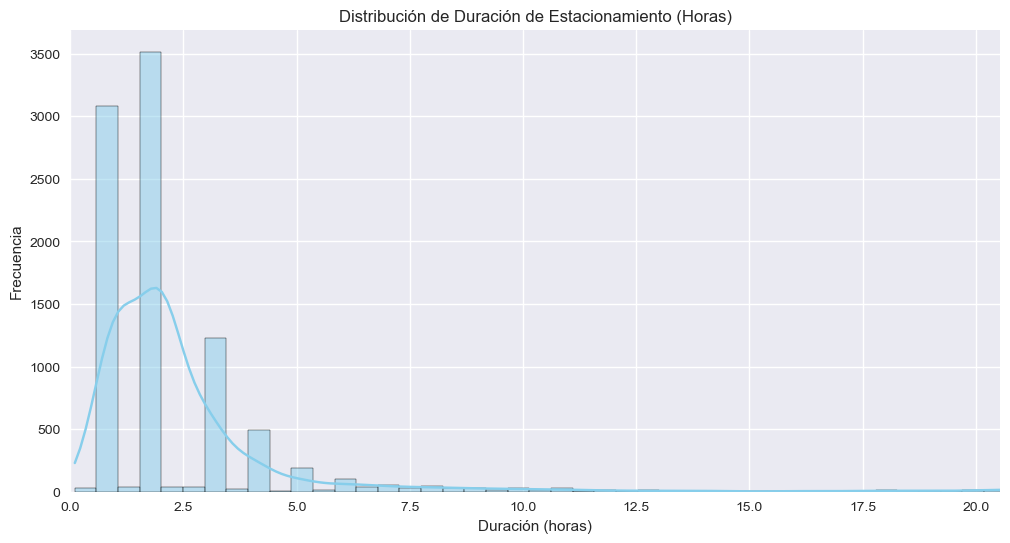

6️⃣ Graficando duración por zonas...


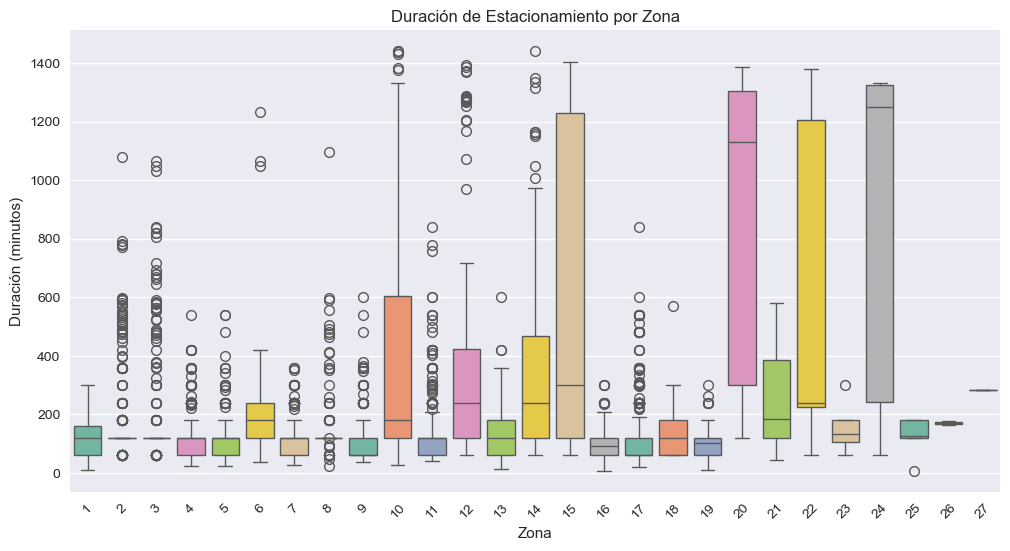

In [8]:
# Graficar distribución de duraciones por horas
print("5️⃣ Graficando distribución de duraciones agrupadas por horas...")
plt.figure(figsize=(12,6))
df['duration_hours'] = df['duration_minutes'] / 60
sns.histplot(df['duration_hours'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de Duración de Estacionamiento (Horas)')
plt.xlabel('Duración (horas)')
plt.ylabel('Frecuencia')
plt.xlim(0, df['duration_hours'].quantile(0.99))  # Limitar eje x al percentil 99 para mejor visualización
plt.show()

# graficar en cajas la duración por zonas
print("6️⃣ Graficando duración por zonas...")
plt.figure(figsize=(12,6))
sns.boxplot(x='zone_number', y='duration_minutes', data=df, palette='Set2')
plt.title('Duración de Estacionamiento por Zona')
plt.xlabel('Zona')
plt.ylabel('Duración (minutos)')
plt.xticks(rotation=45)
plt.show()

In [9]:
# 5. Resumen final de la limpieza
print("5️⃣ RESUMEN FINAL DE LIMPIEZA")
print("=" * 60)

print("📊 Información final del dataset:")
print(df.info())

print(f"\n📈 Estadísticas descriptivas de campos numéricos:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols].describe())

print(f"\n📅 Rango temporal de los datos:")
print(f"   🕐 Inicio más temprano: {df['start_time'].min()}")
print(f"   🕕 Inicio más tardío: {df['start_time'].max()}")
print(f"   📆 Período total: {(df['start_time'].max() - df['start_time'].min()).days} días")

print(f"\n🏢 Información de zonas:")
print(f"   🅿️ Zonas únicas: {df['zone_number'].nunique()}")
print(f"   📊 Zonas disponibles: {sorted(df['zone_number'].unique())}")

# Checkpoint: Guardar dataset limpio
print(f"\n💾 Guardando dataset limpio como checkpoint...")
df.to_pickle('data_cleaned.pkl')
print(f"✅ Dataset limpio guardado: {len(df):,} registros")

print("\n🎉 LIMPIEZA COMPLETADA EXITOSAMENTE")

5️⃣ RESUMEN FINAL DE LIMPIEZA
📊 Información final del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   session_id          9335 non-null   int64              
 1   start_time          9335 non-null   datetime64[ns, UTC]
 2   end_time            9335 non-null   datetime64[ns, UTC]
 3   zone_number         9335 non-null   int64              
 4   parking_fee         9335 non-null   float64            
 5   convenience_fee     9335 non-null   float64            
 6   transaction_fee     9335 non-null   float64            
 7   net_revenue         9335 non-null   float64            
 8   car_id              9335 non-null   int64              
 9   vehicle_state       9335 non-null   object             
 10  transaction_method  9335 non-null   object             
 11  payment_type        9335 non-nul

## 2. Ingeniería de Features y Agregación

In [10]:
# OBJETIVO: Transformar datos transaccionales (nivel session_id) 
# en series de tiempo (nivel zone_number + start_hour)

print("🔄 INGENIERÍA DE FEATURES Y AGREGACIÓN")
print("=" * 60)

# Paso 2.1: Crear start_hour para agregación temporal
print("2.1️⃣ Creando timestamp de agregación horaria...")

df['start_hour'] = df['start_time'].dt.floor('H')
print(f"   📅 start_hour creado: desde {df['start_hour'].min()} hasta {df['start_hour'].max()}")
print(f"   ⏰ Total de horas únicas: {df['start_hour'].nunique()}")

# Verificar que tenemos duration_minutes (ya creado en la limpieza)
print(f"   ✅ duration_minutes disponible: rango {df['duration_minutes'].min():.1f} - {df['duration_minutes'].max():.1f} min")

print("\n" + "="*60)

🔄 INGENIERÍA DE FEATURES Y AGREGACIÓN
2.1️⃣ Creando timestamp de agregación horaria...
   📅 start_hour creado: desde 2025-06-01 04:00:00+00:00 hasta 2025-06-30 03:00:00+00:00
   ⏰ Total de horas únicas: 595
   ✅ duration_minutes disponible: rango 6.0 - 1440.0 min



In [11]:
# Función para calcular la ocupación de vehículos por zona y hora
def calculate_occupancy_by_zone_hour(df):
    """
    Calcula la ocupación por zona y hora considerando vehículos únicos que estuvieron
    presentes durante cada hora, sin importar si permanecieron solo un minuto.
    
    Args:
        df: DataFrame con columnas 'zone_number', 'start_time', 'end_time', 'session_id'
    
    Returns:
        DataFrame con columnas 'zone_number', 'hour', 'occupied_spots'
    """
    print("🚗 Calculando ocupación de vehículos por zona y hora...")
    
    # Lista para almacenar los resultados
    occupancy_results = []
    
    # Obtener el rango de horas completo
    min_hour = df['start_time'].min().floor('H')
    max_hour = df['end_time'].max().floor('H')
    
    # Generar todas las horas en el rango
    all_hours = pd.date_range(start=min_hour, end=max_hour, freq='H')
    
    print(f"   📅 Procesando desde {min_hour} hasta {max_hour}")
    print(f"   ⏰ Total de horas a procesar: {len(all_hours)}")
    
    # Para cada zona
    unique_zones = df['zone_number'].unique()
    print(f"   🏢 Zonas a procesar: {len(unique_zones)}")
    
    for zone in unique_zones:
        zone_data = df[df['zone_number'] == zone].copy()
        
        for hour in all_hours:
            # Calcular el siguiente hora (fin del período)
            next_hour = hour + pd.Timedelta(hours=1)
            
            # Encontrar vehículos que estuvieron presentes durante esta hora
            # Un vehículo está presente si:
            # - Su start_time es antes del final de la hora (hour + 1)
            # - Su end_time es después del inicio de la hora
            vehicles_present = zone_data[
                (zone_data['start_time'] < next_hour) & 
                (zone_data['end_time'] > hour)
            ]
            
            # Contar vehículos únicos (session_id únicos)
            occupied_spots = vehicles_present['session_id'].nunique()
            
            # Agregar resultado
            occupancy_results.append({
                'zone_number': zone,
                'hour': hour,
                'occupied_spots': occupied_spots
            })
    
    # Convertir a DataFrame
    occupancy_df = pd.DataFrame(occupancy_results)
    
    print(f"   ✅ Ocupación calculada: {len(occupancy_df)} registros")
    print(f"   📊 Rango de ocupación: {occupancy_df['occupied_spots'].min()} - {occupancy_df['occupied_spots'].max()} vehículos")
    
    return occupancy_df

# Ejecutar la función
occupancy_data = calculate_occupancy_by_zone_hour(df)

# Mostrar estadísticas de la ocupación
print(f"\n📋 Estadísticas de ocupación:")
print(f"   🏢 Zonas únicas: {occupancy_data['zone_number'].nunique()}")
print(f"   ⏰ Horas únicas: {occupancy_data['hour'].nunique()}")
print(f"   📊 Ocupación promedio: {occupancy_data['occupied_spots'].mean():.2f} vehículos")
print(f"   📈 Ocupación máxima: {occupancy_data['occupied_spots'].max()} vehículos")

# Mostrar algunos ejemplos
print(f"\n📋 Ejemplos de ocupación:")
sample_data = occupancy_data[occupancy_data['occupied_spots'] > 0].head(10)
for _, row in sample_data.iterrows():
    print(f"   🕐 {row['hour'].strftime('%Y-%m-%d %H:%M')} | Zona {row['zone_number']} | {row['occupied_spots']} vehículos")

print("\n" + "="*60)

🚗 Calculando ocupación de vehículos por zona y hora...
   📅 Procesando desde 2025-06-01 04:00:00+00:00 hasta 2025-06-30 10:00:00+00:00
   ⏰ Total de horas a procesar: 703
   🏢 Zonas a procesar: 27
   ✅ Ocupación calculada: 18981 registros
   📊 Rango de ocupación: 0 - 35 vehículos

📋 Estadísticas de ocupación:
   🏢 Zonas únicas: 27
   ⏰ Horas únicas: 703
   📊 Ocupación promedio: 1.75 vehículos
   📈 Ocupación máxima: 35 vehículos

📋 Ejemplos de ocupación:
   🕐 2025-06-01 16:00 | Zona 1 | 1 vehículos
   🕐 2025-06-01 17:00 | Zona 1 | 1 vehículos
   🕐 2025-06-01 18:00 | Zona 1 | 1 vehículos
   🕐 2025-06-01 19:00 | Zona 1 | 2 vehículos
   🕐 2025-06-01 20:00 | Zona 1 | 2 vehículos
   🕐 2025-06-01 21:00 | Zona 1 | 2 vehículos
   🕐 2025-06-01 22:00 | Zona 1 | 1 vehículos
   🕐 2025-06-01 23:00 | Zona 1 | 3 vehículos
   🕐 2025-06-02 22:00 | Zona 1 | 2 vehículos
   🕐 2025-06-02 23:00 | Zona 1 | 2 vehículos

   ✅ Ocupación calculada: 18981 registros
   📊 Rango de ocupación: 0 - 35 vehículos

📋 Esta

In [12]:
# Paso 2.2: AGREGACIÓN CRÍTICA 
print("2.2️⃣ Realizando agregación por [zone_number, start_hour]...")

# Definir las métricas de agregación según la hipótesis
aggregation_dict = {
    'session_id': 'nunique',  # transaction_count
    'net_revenue': 'sum',     # total_net_revenue  
    'duration_minutes': 'mean'  # avg_duration
}

# Realizar la agregación
df_agg = df.groupby(['zone_number', 'start_hour']).agg(aggregation_dict).reset_index()

# Renombrar columnas para claridad
df_agg.columns = ['zone_number', 'start_hour', 'transaction_count', 'total_net_revenue', 'avg_duration_minutes']

print(f"   📊 Dataset agregado creado: {df_agg.shape}")
print(f"   🏢 Zonas en agregación: {df_agg['zone_number'].nunique()}")
print(f"   ⏰ Horas en agregación: {df_agg['start_hour'].nunique()}")
print(f"   🔢 Total de combinaciones zona-hora: {len(df_agg):,}")

# AGREGAR OCUPACIÓN: Integrar datos de ocupación calculados anteriormente
print("\n🚗 Integrando datos de ocupación...")

# Renombrar la columna 'hour' a 'start_hour' para hacer el merge
occupancy_for_merge = occupancy_data.rename(columns={'hour': 'start_hour'})

# Hacer merge con los datos de ocupación
df_agg = df_agg.merge(
    occupancy_for_merge[['zone_number', 'start_hour', 'occupied_spots']], 
    on=['zone_number', 'start_hour'], 
    how='left'
)

# Rellenar valores faltantes de ocupación con 0
df_agg['occupied_spots'] = df_agg['occupied_spots'].fillna(0).astype(int)

print(f"   ✅ Ocupación integrada exitosamente")
print(f"   📊 Rango de ocupación en agregación: {df_agg['occupied_spots'].min()} - {df_agg['occupied_spots'].max()} vehículos")

# Mostrar primeras filas con la nueva columna de ocupación
print(f"\n📋 Primeras 10 filas del dataset agregado con ocupación:")
display(df_agg.head(10))

# Mostrar estadísticas de la ocupación en el dataset agregado
print(f"\n📊 Estadísticas de ocupación en dataset agregado:")
print(f"   🏢 Zonas con ocupación > 0: {(df_agg['occupied_spots'] > 0).sum()}")
print(f"   📈 Ocupación promedio: {df_agg['occupied_spots'].mean():.2f} vehículos")
print(f"   📊 Distribución de ocupación:")
print(df_agg['occupied_spots'].value_counts().sort_index().head(10))

print("\n" + "="*60)

2.2️⃣ Realizando agregación por [zone_number, start_hour]...
   📊 Dataset agregado creado: (4458, 5)
   🏢 Zonas en agregación: 27
   ⏰ Horas en agregación: 595
   🔢 Total de combinaciones zona-hora: 4,458

🚗 Integrando datos de ocupación...
   ✅ Ocupación integrada exitosamente
   📊 Rango de ocupación en agregación: 1 - 35 vehículos

📋 Primeras 10 filas del dataset agregado con ocupación:


,zone_number,start_hour,transaction_count,total_net_revenue,avg_duration_minutes,occupied_spots
0,1,2025-06-01 16:00:00+00:00,1,5.23,180.0,1
1,1,2025-06-01 19:00:00+00:00,1,3.23,120.0,2
2,1,2025-06-01 20:00:00+00:00,1,5.23,180.0,2
3,1,2025-06-01 23:00:00+00:00,2,2.46,36.0,3
4,1,2025-06-02 22:00:00+00:00,2,6.46,85.5,2
5,1,2025-06-05 23:00:00+00:00,1,1.23,41.0,1
6,1,2025-06-06 21:00:00+00:00,1,3.23,120.0,1
7,1,2025-06-06 23:00:00+00:00,1,1.23,10.0,2
8,1,2025-06-07 19:00:00+00:00,2,8.46,150.0,2
9,1,2025-06-07 20:00:00+00:00,1,5.23,180.0,3



📊 Estadísticas de ocupación en dataset agregado:
   🏢 Zonas con ocupación > 0: 4458
   📈 Ocupación promedio: 5.39 vehículos
   📊 Distribución de ocupación:
occupied_spots
1     646
2     670
3     559
4     497
5     424
6     351
7     248
8     224
9     183
10    140
Name: count, dtype: int64



In [13]:
# Paso 2.3: Re-indexación y Features Temporales
print("2.3️⃣ Creando índice completo y features temporales...")

# Crear un índice completo para todas las combinaciones zona-hora
# Esto es crucial para rellenar períodos sin actividad con ceros

zones = df_agg['zone_number'].unique()
hours = pd.date_range(
    start=df_agg['start_hour'].min(),
    end=df_agg['start_hour'].max(),
    freq='H'
)

print(f"   🏢 Zonas únicas: {len(zones)} ({sorted(zones)})")
print(f"   ⏰ Período temporal: {len(hours)} horas ({hours.min()} a {hours.max()})")

# Crear el índice completo
full_index = pd.MultiIndex.from_product([zones, hours], names=['zone_number', 'start_hour'])
print(f"   📊 Combinaciones teóricas zona-hora: {len(full_index):,}")

# Reindexar el dataset agregado
df_agg_complete = df_agg.set_index(['zone_number', 'start_hour']).reindex(full_index).reset_index()

# Rellenar valores faltantes con 0 (períodos sin actividad)
# IMPORTANTE: Incluir occupied_spots para que períodos sin actividad tengan ocupación = 0
fill_columns = ['transaction_count', 'total_net_revenue', 'occupied_spots']
df_agg_complete[fill_columns] = df_agg_complete[fill_columns].fillna(0)

# Para avg_duration, usar la mediana de la zona (no tiene sentido poner 0)
df_agg_complete['avg_duration_minutes'] = df_agg_complete.groupby('zone_number')['avg_duration_minutes'].transform(
    lambda x: x.fillna(x.median())
)

# Convertir occupied_spots a entero para evitar decimales innecesarios
df_agg_complete['occupied_spots'] = df_agg_complete['occupied_spots'].astype(int)

print(f"   ✅ Dataset completo creado: {df_agg_complete.shape}")
print(f"   📊 Filas agregadas (períodos sin actividad): {len(df_agg_complete) - len(df_agg):,}")

# Verificar que no hay valores NaN en occupied_spots
print(f"   🚗 Valores NaN en occupied_spots: {df_agg_complete['occupied_spots'].isna().sum()}")
print(f"   📊 Rango de occupied_spots: {df_agg_complete['occupied_spots'].min()} - {df_agg_complete['occupied_spots'].max()}")

# Mostrar estadísticas de ocupación en el dataset completo
print(f"\n📊 Estadísticas de ocupación en dataset completo:")
print(f"   🏢 Registros con ocupación = 0: {(df_agg_complete['occupied_spots'] == 0).sum():,}")
print(f"   🚗 Registros con ocupación > 0: {(df_agg_complete['occupied_spots'] > 0).sum():,}")
print(f"   📈 Ocupación promedio: {df_agg_complete['occupied_spots'].mean():.2f} vehículos")

print("\n" + "="*60)

2.3️⃣ Creando índice completo y features temporales...
   🏢 Zonas únicas: 27 ([np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27)])
   ⏰ Período temporal: 696 horas (2025-06-01 04:00:00+00:00 a 2025-06-30 03:00:00+00:00)
   📊 Combinaciones teóricas zona-hora: 18,792
   ✅ Dataset completo creado: (18792, 6)
   📊 Filas agregadas (períodos sin actividad): 14,334
   🚗 Valores NaN en occupied_spots: 0
   📊 Rango de occupied_spots: 0 - 35

📊 Estadísticas de ocupación en dataset completo:
   🏢 Registros con ocupación = 0: 14,334
   🚗 Registros con ocupación > 0: 4,458
   📈 Ocupación promedio: 1.28 vehículos



In [14]:
df_agg_complete

,zone_number,start_hour,transaction_count,total_net_revenue,avg_duration_minutes,occupied_spots
0,1,2025-06-01 04:00:00+00:00,0.0,0.0,120.0,0
1,1,2025-06-01 05:00:00+00:00,0.0,0.0,120.0,0
2,1,2025-06-01 06:00:00+00:00,0.0,0.0,120.0,0
3,1,2025-06-01 07:00:00+00:00,0.0,0.0,120.0,0
4,1,2025-06-01 08:00:00+00:00,0.0,0.0,120.0,0
...,...,...,...,...,...,...
18787,27,2025-06-29 23:00:00+00:00,0.0,0.0,284.0,0
18788,27,2025-06-30 00:00:00+00:00,0.0,0.0,284.0,0
18789,27,2025-06-30 01:00:00+00:00,0.0,0.0,284.0,0
18790,27,2025-06-30 02:00:00+00:00,0.0,0.0,284.0,0


In [15]:
# crear lista para la capacidad de las zonas
zone_capacity = {
    1: 50,
    2: 45,
    3: 30,
    4: 60,
    5: 80,
    6: 30,
    7: 55,
    8: 40,
    9: 45,
    10: 95,
    11: 65,
    12: 40,
    13: 30,
    14: 30,
    15: 40,
    16: 50,
    17: 75,
    18: 50,
    19: 50,
    20: 55,
    21: 54,
    22: 55,
    23: 38,
    24: 58,
    25: 59,
    26: 65,
    27: 32
}


# la lista de capacidades por zona es un dato inventado y aleatorio no proporcionado en le dataset, se asume para el ejemplo
print("🔢 Añadiendo capacidad de zonas al dataset, datos inventados ...")

# unir la capacidad al dataframe agregado
df_agg_complete['zone_capacity'] = df_agg_complete['zone_number'].map(zone_capacity)
print("✅ Capacidad de zonas añadida al dataset agregado")

# Calcular rate de ocupación por zona y hora
df_agg_complete['occupancy_rate'] = df_agg_complete['occupied_spots'] / df_agg_complete['zone_capacity']
print("✅ Tasa de ocupación calculada y añadida al dataset agregado")

df_agg_complete

🔢 Añadiendo capacidad de zonas al dataset, datos inventados ...
✅ Capacidad de zonas añadida al dataset agregado
✅ Tasa de ocupación calculada y añadida al dataset agregado


,zone_number,start_hour,transaction_count,total_net_revenue,avg_duration_minutes,occupied_spots,zone_capacity,occupancy_rate
0,1,2025-06-01 04:00:00+00:00,0.0,0.0,120.0,0,50,0.0
1,1,2025-06-01 05:00:00+00:00,0.0,0.0,120.0,0,50,0.0
2,1,2025-06-01 06:00:00+00:00,0.0,0.0,120.0,0,50,0.0
3,1,2025-06-01 07:00:00+00:00,0.0,0.0,120.0,0,50,0.0
4,1,2025-06-01 08:00:00+00:00,0.0,0.0,120.0,0,50,0.0
...,...,...,...,...,...,...,...,...
18787,27,2025-06-29 23:00:00+00:00,0.0,0.0,284.0,0,32,0.0
18788,27,2025-06-30 00:00:00+00:00,0.0,0.0,284.0,0,32,0.0
18789,27,2025-06-30 01:00:00+00:00,0.0,0.0,284.0,0,32,0.0
18790,27,2025-06-30 02:00:00+00:00,0.0,0.0,284.0,0,32,0.0


In [16]:
# Crear features temporales cíclicas para modelos ML
print("⏰ Creando features temporales cíclicas... (aumentado de datos en funcion del tiempo)")

# Features temporales básicas
df_agg_complete['hour_of_day'] = df_agg_complete['start_hour'].dt.hour
df_agg_complete['day_of_week'] = df_agg_complete['start_hour'].dt.dayofweek  # 0=Lunes, 6=Domingo
df_agg_complete['is_weekend'] = (df_agg_complete['day_of_week'] >= 5).astype(int)
df_agg_complete['day_of_month'] = df_agg_complete['start_hour'].dt.day
df_agg_complete['month'] = df_agg_complete['start_hour'].dt.month

# Features cíclicas (importantes para ML)
# Convertir hora del día a componentes circulares
df_agg_complete['hour_sin'] = np.sin(2 * np.pi * df_agg_complete['hour_of_day'] / 24)
df_agg_complete['hour_cos'] = np.cos(2 * np.pi * df_agg_complete['hour_of_day'] / 24)

# Convertir día de la semana a componentes circulares
df_agg_complete['dow_sin'] = np.sin(2 * np.pi * df_agg_complete['day_of_week'] / 7)
df_agg_complete['dow_cos'] = np.cos(2 * np.pi * df_agg_complete['day_of_week'] / 7)

print(f"   ✅ Features temporales creadas:")
temporal_features = ['hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month',
                    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'] # hour_sin (horas del día senosoidal), hour_cos (horas del día cosenoidal), dow_sin (días de la semana senosoidal), dow_cos (días de la semana cosenoidal)
print(f"      {temporal_features}")

# Mostrar estadísticas del dataset final
print(f"\n📊 DATASET FINAL PARA MODELOS:")
print(f"   📏 Dimensiones: {df_agg_complete.shape}")
print(f"   📋 Columnas: {list(df_agg_complete.columns)}")

# Verificar que no hay valores nulos en métricas clave
null_counts = df_agg_complete[['transaction_count', 'total_net_revenue', 'avg_duration_minutes', 'occupancy_rate']].isnull().sum()
print(f"\n   🔍 Valores nulos en métricas clave:")
for col, nulls in null_counts.items():
    print(f"      {col}: {nulls}")

# Guardar dataset agregado
df_agg_complete.to_pickle('data_aggregated.pkl')
print(f"\n💾 Dataset agregado guardado: {len(df_agg_complete):,} registros")

print("\n🎉 INGENIERÍA DE FEATURES COMPLETADA")

⏰ Creando features temporales cíclicas... (aumentado de datos en funcion del tiempo)
   ✅ Features temporales creadas:
      ['hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

📊 DATASET FINAL PARA MODELOS:
   📏 Dimensiones: (18792, 17)
   📋 Columnas: ['zone_number', 'start_hour', 'transaction_count', 'total_net_revenue', 'avg_duration_minutes', 'occupied_spots', 'zone_capacity', 'occupancy_rate', 'hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

   🔍 Valores nulos en métricas clave:
      transaction_count: 0
      total_net_revenue: 0
      avg_duration_minutes: 0
      occupancy_rate: 0

💾 Dataset agregado guardado: 18,792 registros

🎉 INGENIERÍA DE FEATURES COMPLETADA


In [17]:
df_agg_complete.tail(10)

,zone_number,start_hour,transaction_count,total_net_revenue,avg_duration_minutes,occupied_spots,zone_capacity,occupancy_rate,hour_of_day,day_of_week,is_weekend,day_of_month,month,hour_sin,hour_cos,dow_sin,dow_cos
18782,27,2025-06-29 18:00:00+00:00,0.0,0.0,284.0,0,32,0.0,18,6,1,29,6,-1.000000,-1.836970e-16,-0.781831,0.62349
18783,27,2025-06-29 19:00:00+00:00,0.0,0.0,284.0,0,32,0.0,19,6,1,29,6,-0.965926,2.588190e-01,-0.781831,0.62349
18784,27,2025-06-29 20:00:00+00:00,0.0,0.0,284.0,0,32,0.0,20,6,1,29,6,-0.866025,5.000000e-01,-0.781831,0.62349
18785,27,2025-06-29 21:00:00+00:00,0.0,0.0,284.0,0,32,0.0,21,6,1,29,6,-0.707107,7.071068e-01,-0.781831,0.62349
18786,27,2025-06-29 22:00:00+00:00,0.0,0.0,284.0,0,32,0.0,22,6,1,29,6,-0.500000,8.660254e-01,-0.781831,0.62349
18787,27,2025-06-29 23:00:00+00:00,0.0,0.0,284.0,0,32,0.0,23,6,1,29,6,-0.258819,9.659258e-01,-0.781831,0.62349
18788,27,2025-06-30 00:00:00+00:00,0.0,0.0,284.0,0,32,0.0,0,0,0,30,6,0.000000,1.000000e+00,0.000000,1.00000
18789,27,2025-06-30 01:00:00+00:00,0.0,0.0,284.0,0,32,0.0,1,0,0,30,6,0.258819,9.659258e-01,0.000000,1.00000
18790,27,2025-06-30 02:00:00+00:00,0.0,0.0,284.0,0,32,0.0,2,0,0,30,6,0.500000,8.660254e-01,0.000000,1.00000
18791,27,2025-06-30 03:00:00+00:00,0.0,0.0,284.0,0,32,0.0,3,0,0,30,6,0.707107,7.071068e-01,0.000000,1.00000


In [18]:
# Verificar columnas del dataset
print("Columnas disponibles en df_agg_complete:")
print(df_agg_complete.columns.tolist())
print(f"\nForma del dataset: {df_agg_complete.shape}")

# Verificar si existen zone_capacity y occupancy_rate
print(f"\n¿Existe zone_capacity? {'zone_capacity' in df_agg_complete.columns}")
print(f"¿Existe occupancy_rate? {'occupancy_rate' in df_agg_complete.columns}")

if 'occupancy_rate' in df_agg_complete.columns:
    print(f"\nRango de occupancy_rate: {df_agg_complete['occupancy_rate'].min():.3f} - {df_agg_complete['occupancy_rate'].max():.3f}")
    print(f"Valores nulos en occupancy_rate: {df_agg_complete['occupancy_rate'].isnull().sum()}")
    
if 'zone_capacity' in df_agg_complete.columns:
    print(f"\nValores únicos de zone_capacity por zona:")
    print(df_agg_complete[['zone_number', 'zone_capacity']].drop_duplicates().sort_values('zone_number'))

Columnas disponibles en df_agg_complete:
['zone_number', 'start_hour', 'transaction_count', 'total_net_revenue', 'avg_duration_minutes', 'occupied_spots', 'zone_capacity', 'occupancy_rate', 'hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

Forma del dataset: (18792, 17)

¿Existe zone_capacity? True
¿Existe occupancy_rate? True

Rango de occupancy_rate: 0.000 - 1.067
Valores nulos en occupancy_rate: 0

Valores únicos de zone_capacity por zona:
       zone_number  zone_capacity
0                1             50
696              2             45
1392             3             30
2088             4             60
2784             5             80
3480             6             30
4176             7             55
4872             8             40
5568             9             45
6264            10             95
6960            11             65
7656            12             40
8352            13             30
9048       

## 3. Análisis Exploratorio (EDA) - Enfocado en Series de Tiempo

In [19]:
print("🔍 ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
print("=" * 60)
print("📊 Validando supuestos de la hipótesis: patrones diarios, semanales y estacionales")
print("⚠️  Limitación: Solo tenemos datos de Junio (1 mes)\n")

# Verificar que tenemos el dataset agregado disponible
if 'df_agg_complete' not in locals():
    print("⚠️  Cargando dataset agregado desde archivo...")
    df_agg_complete = pd.read_pickle('data_aggregated.pkl')
    print(f"✅ Dataset cargado: {df_agg_complete.shape}")

# Resumen básico del dataset
print("📋 RESUMEN DEL DATASET AGREGADO:")
print(f"   📊 Forma: {df_agg_complete.shape}")
print(f"   📅 Período: {df_agg_complete['start_hour'].min()} a {df_agg_complete['start_hour'].max()}")
print(f"   🏢 Zonas únicas: {df_agg_complete['zone_number'].nunique()}")
print(f"   ⏰ Horas únicas: {df_agg_complete['start_hour'].nunique()}")

print("\n" + "="*60)

🔍 ANÁLISIS EXPLORATORIO DE DATOS (EDA)
📊 Validando supuestos de la hipótesis: patrones diarios, semanales y estacionales
⚠️  Limitación: Solo tenemos datos de Junio (1 mes)

📋 RESUMEN DEL DATASET AGREGADO:
   📊 Forma: (18792, 17)
   📅 Período: 2025-06-01 04:00:00+00:00 a 2025-06-30 03:00:00+00:00
   🏢 Zonas únicas: 27
   ⏰ Horas únicas: 696



### 3.1 Análisis de Cardinalidad - Distribución por Zonas

In [20]:
print("3.1️⃣ ANÁLISIS DE CARDINALIDAD - DISTRIBUCIÓN POR ZONAS")
print("=" * 60)

# Análisis de zonas únicas
zones_unique = df_agg_complete['zone_number'].nunique()
zones_list = sorted(df_agg_complete['zone_number'].unique())

print(f"🏢 Zonas únicas en el dataset: {zones_unique}")
print(f"📋 Lista de zonas: {zones_list}")

# Análisis de distribución de datos por zona
zone_stats = df_agg_complete.groupby('zone_number').agg({
    'transaction_count': ['count', 'sum', 'mean'],
    'total_net_revenue': ['sum', 'mean'],
    'occupied_spots': ['mean', 'max'],
    'occupancy_rate': ['mean', 'max']
}).round(2)

# Aplanar nombres de columnas
zone_stats.columns = ['_'.join(col).strip() for col in zone_stats.columns]
zone_stats = zone_stats.reset_index()

print(f"\n📊 Estadísticas por zona (primeras 10):")
display(zone_stats.head(10))

# Identificar zonas con pocos datos
min_records_threshold = df_agg_complete['start_hour'].nunique() * 0.5  # Al menos 50% de las horas
zones_low_data = zone_stats[zone_stats['transaction_count_count'] < min_records_threshold]

print(f"\n⚠️  Zonas con pocos datos (< {min_records_threshold:.0f} registros):")
if len(zones_low_data) > 0:
    print(f"   🚨 {len(zones_low_data)} zonas con datos insuficientes:")
    for _, row in zones_low_data.iterrows():
        print(f"      Zona {row['zone_number']}: {row['transaction_count_count']} registros")
else:
    print("   ✅ Todas las zonas tienen datos suficientes")

print("\n" + "="*60)

3.1️⃣ ANÁLISIS DE CARDINALIDAD - DISTRIBUCIÓN POR ZONAS
🏢 Zonas únicas en el dataset: 27
📋 Lista de zonas: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27)]

📊 Estadísticas por zona (primeras 10):


,zone_number,transaction_count_count,transaction_count_sum,transaction_count_mean,total_net_revenue_sum,total_net_revenue_mean,occupied_spots_mean,occupied_spots_max,occupancy_rate_mean,occupancy_rate_max
0,1,696,74.0,0.11,243.02,0.35,0.18,6,0.00,0.12
1,2,696,890.0,1.28,437.90,0.63,3.54,21,0.08,0.47
2,3,696,402.0,0.58,441.36,0.63,1.35,9,0.04,0.30
3,4,696,807.0,1.16,4767.61,6.85,2.89,22,0.05,0.37
4,5,696,641.0,0.92,2569.93,3.69,2.20,17,0.03,0.21
5,6,696,661.0,0.95,10039.51,14.42,3.06,32,0.10,1.07
6,7,696,943.0,1.35,3761.39,5.40,3.48,20,0.06,0.36
7,8,696,307.0,0.44,182.71,0.26,0.88,9,0.02,0.22
8,9,696,386.0,0.55,2259.28,3.25,1.15,9,0.03,0.20
9,10,696,322.0,0.46,2524.06,3.63,1.36,15,0.01,0.16



⚠️  Zonas con pocos datos (< 348 registros):
   ✅ Todas las zonas tienen datos suficientes



### 3.2 Validación de Estacionalidad (Crítico) - Patrones Diarios y Semanales

In [22]:
print("3.2️⃣ VALIDACIÓN DE ESTACIONALIDAD - PATRONES DIARIOS Y SEMANALES")
print("=" * 60)

# PATRÓN DIARIO: Análisis por hora del día
print("📅 PATRÓN DIARIO - Análisis por hora del día")
daily_pattern = df_agg_complete.groupby('hour_of_day').agg({
    'transaction_count': ['mean', 'std', 'sum'],
    'total_net_revenue': ['mean', 'std'],
    'occupancy_rate': ['mean', 'std'],
    'occupied_spots': ['mean', 'std']
}).round(2)

# Aplanar nombres de columnas
daily_pattern.columns = ['_'.join(col).strip() for col in daily_pattern.columns]
daily_pattern = daily_pattern.reset_index()

print("📊 Estadísticas por hora del día (0-23):")
display(daily_pattern)

# Identificar horas pico y valle
peak_hours = daily_pattern.nlargest(3, 'transaction_count_mean')['hour_of_day'].values
valley_hours = daily_pattern.nsmallest(3, 'transaction_count_mean')['hour_of_day'].values

print(f"\n⏰ Horas PICO (mayor actividad): {peak_hours}")
print(f"🌙 Horas VALLE (menor actividad): {valley_hours}")

# Verificar hipótesis: valles en madrugada, picos durante el día
madrugada = daily_pattern[(daily_pattern['hour_of_day'] >= 0) & (daily_pattern['hour_of_day'] <= 6)]
dia_activo = daily_pattern[(daily_pattern['hour_of_day'] >= 8) & (daily_pattern['hour_of_day'] <= 18)]

print(f"\n🔍 VALIDACIÓN DE HIPÓTESIS - PATRÓN DIARIO:")
print(f"   🌙 Transacciones promedio en madrugada (0-6h): {madrugada['transaction_count_mean'].mean():.2f}")
print(f"   ☀️ Transacciones promedio en día activo (8-18h): {dia_activo['transaction_count_mean'].mean():.2f}")
print(f"   📈 Ratio día/madrugada: {dia_activo['transaction_count_mean'].mean() / madrugada['transaction_count_mean'].mean():.1f}x")

if dia_activo['transaction_count_mean'].mean() > madrugada['transaction_count_mean'].mean() * 2:
    print("   ✅ HIPÓTESIS CONFIRMADA: Existe patrón diario claro")
else:
    print("   ⚠️  HIPÓTESIS PARCIAL: Patrón diario menos marcado de lo esperado")

print("\n" + "="*60)

3.2️⃣ VALIDACIÓN DE ESTACIONALIDAD - PATRONES DIARIOS Y SEMANALES
📅 PATRÓN DIARIO - Análisis por hora del día
📊 Estadísticas por hora del día (0-23):


,hour_of_day,transaction_count_mean,transaction_count_std,transaction_count_sum,total_net_revenue_mean,total_net_revenue_std,occupancy_rate_mean,occupancy_rate_std,occupied_spots_mean,occupied_spots_std
0,0,0.60,1.19,467.0,2.60,6.25,0.03,0.07,1.73,3.46
1,1,0.48,1.02,374.0,2.23,5.63,0.03,0.07,1.51,3.28
2,2,0.39,0.89,302.0,1.81,5.99,0.02,0.07,1.18,2.83
3,3,0.28,0.81,222.0,1.46,6.55,0.02,0.07,0.87,2.60
4,4,0.18,0.65,138.0,0.64,3.20,0.02,0.08,0.67,2.71
5,5,0.08,0.40,66.0,0.24,1.58,0.01,0.07,0.39,2.21
6,6,0.03,0.20,27.0,0.03,0.34,0.00,0.04,0.18,1.37
7,7,0.01,0.09,6.0,0.00,0.05,0.00,0.02,0.03,0.72
8,8,0.01,0.07,4.0,-0.00,0.01,0.00,0.01,0.01,0.22
9,9,0.00,0.05,2.0,-0.00,0.01,0.00,0.00,0.01,0.10



⏰ Horas PICO (mayor actividad): [16 17 15]
🌙 Horas VALLE (menor actividad): [9 7 8]

🔍 VALIDACIÓN DE HIPÓTESIS - PATRÓN DIARIO:
   🌙 Transacciones promedio en madrugada (0-6h): 0.29
   ☀️ Transacciones promedio en día activo (8-18h): 0.54
   📈 Ratio día/madrugada: 1.8x
   ⚠️  HIPÓTESIS PARCIAL: Patrón diario menos marcado de lo esperado



In [23]:
# PATRÓN SEMANAL: Análisis por día de la semana
print("📅 PATRÓN SEMANAL - Análisis por día de la semana")

# Mapeo de días para mejor interpretación
day_names = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 
             4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}

weekly_pattern = df_agg_complete.groupby('day_of_week').agg({
    'transaction_count': ['mean', 'std', 'sum'],
    'total_net_revenue': ['mean', 'std'],
    'occupancy_rate': ['mean', 'std'],
    'occupied_spots': ['mean', 'std']
}).round(2)

# Aplanar nombres de columnas
weekly_pattern.columns = ['_'.join(col).strip() for col in weekly_pattern.columns]
weekly_pattern = weekly_pattern.reset_index()
weekly_pattern['day_name'] = weekly_pattern['day_of_week'].map(day_names)

print("📊 Estadísticas por día de la semana:")
display(weekly_pattern[['day_name', 'transaction_count_mean', 'transaction_count_std', 
                        'total_net_revenue_mean', 'occupancy_rate_mean']])

# Separar días laborales vs fin de semana
weekdays = weekly_pattern[weekly_pattern['day_of_week'] < 5]  # Lunes a Viernes
weekends = weekly_pattern[weekly_pattern['day_of_week'] >= 5]  # Sábado y Domingo

print(f"\n🔍 VALIDACIÓN DE HIPÓTESIS - PATRÓN SEMANAL:")
print(f"   💼 Transacciones promedio días laborales (L-V): {weekdays['transaction_count_mean'].mean():.2f}")
print(f"   🏖️ Transacciones promedio fin de semana (S-D): {weekends['transaction_count_mean'].mean():.2f}")
print(f"   📈 Ratio laboral/fin de semana: {weekdays['transaction_count_mean'].mean() / weekends['transaction_count_mean'].mean():.2f}x")

# Determinar si hay diferencia significativa
if abs(weekdays['transaction_count_mean'].mean() - weekends['transaction_count_mean'].mean()) > 1:
    if weekdays['transaction_count_mean'].mean() > weekends['transaction_count_mean'].mean():
        print("   ✅ HIPÓTESIS CONFIRMADA: Días laborales más activos que fin de semana")
    else:
        print("   🔄 HIPÓTESIS INVERTIDA: Fin de semana más activo que días laborales")
else:
    print("   ⚠️  HIPÓTESIS PARCIAL: Diferencia mínima entre laboral y fin de semana")

print("\n" + "="*60)

📅 PATRÓN SEMANAL - Análisis por día de la semana
📊 Estadísticas por día de la semana:


,day_name,transaction_count_mean,transaction_count_std,total_net_revenue_mean,occupancy_rate_mean
0,Lunes,0.37,0.92,1.72,0.02
1,Martes,0.40,0.96,1.95,0.02
2,Miércoles,0.39,0.99,2.04,0.02
3,Jueves,0.43,1.03,2.00,0.02
4,Viernes,0.50,1.13,2.42,0.03
5,Sábado,0.74,1.58,4.49,0.04
6,Domingo,0.63,1.33,3.45,0.04



🔍 VALIDACIÓN DE HIPÓTESIS - PATRÓN SEMANAL:
   💼 Transacciones promedio días laborales (L-V): 0.42
   🏖️ Transacciones promedio fin de semana (S-D): 0.69
   📈 Ratio laboral/fin de semana: 0.61x
   ⚠️  HIPÓTESIS PARCIAL: Diferencia mínima entre laboral y fin de semana



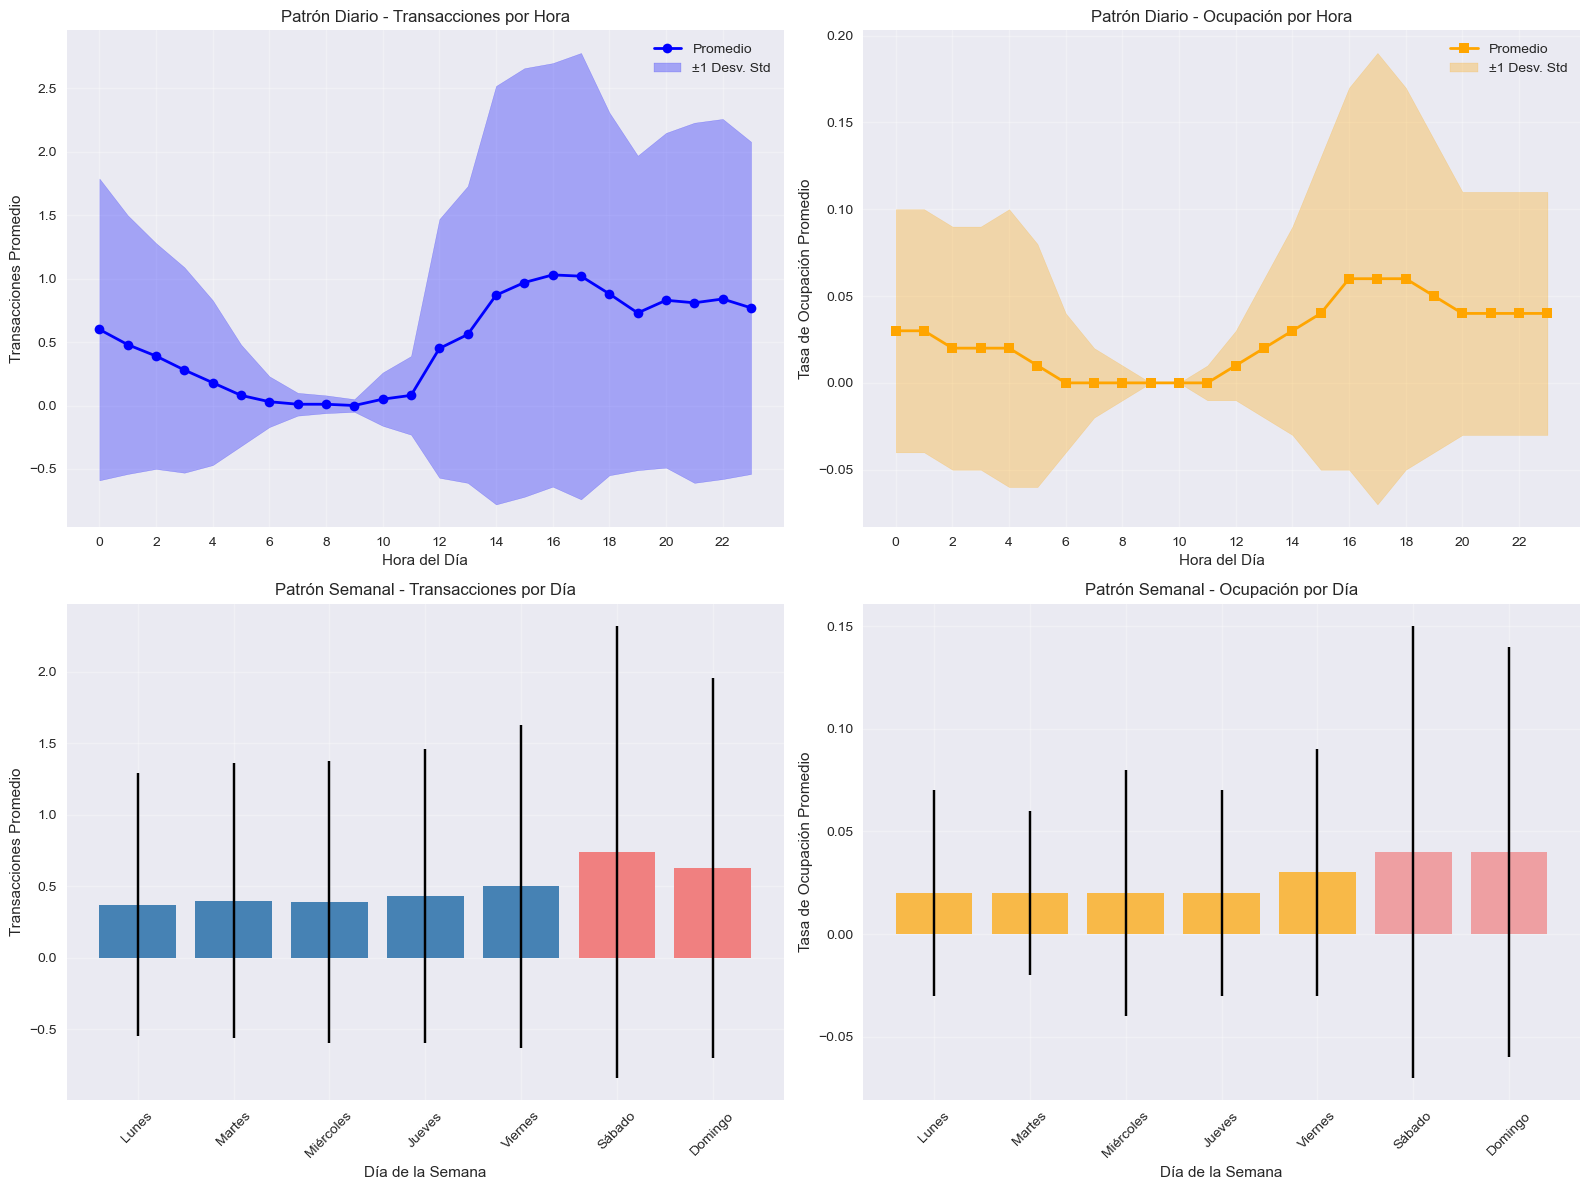

📊 Visualizaciones de patrones temporales completadas


In [24]:
# Visualización de patrones temporales
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Patrón diario - Transacciones por hora
axes[0,0].plot(daily_pattern['hour_of_day'], daily_pattern['transaction_count_mean'], 
               marker='o', linewidth=2, color='blue', label='Promedio')
axes[0,0].fill_between(daily_pattern['hour_of_day'], 
                       daily_pattern['transaction_count_mean'] - daily_pattern['transaction_count_std'],
                       daily_pattern['transaction_count_mean'] + daily_pattern['transaction_count_std'],
                       alpha=0.3, color='blue', label='±1 Desv. Std')
axes[0,0].set_title('Patrón Diario - Transacciones por Hora')
axes[0,0].set_xlabel('Hora del Día')
axes[0,0].set_ylabel('Transacciones Promedio')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()
axes[0,0].set_xticks(range(0, 24, 2))

# 2. Patrón diario - Ocupación por hora
axes[0,1].plot(daily_pattern['hour_of_day'], daily_pattern['occupancy_rate_mean'], 
               marker='s', linewidth=2, color='orange', label='Promedio')
axes[0,1].fill_between(daily_pattern['hour_of_day'], 
                       daily_pattern['occupancy_rate_mean'] - daily_pattern['occupancy_rate_std'],
                       daily_pattern['occupancy_rate_mean'] + daily_pattern['occupancy_rate_std'],
                       alpha=0.3, color='orange', label='±1 Desv. Std')
axes[0,1].set_title('Patrón Diario - Ocupación por Hora')
axes[0,1].set_xlabel('Hora del Día')
axes[0,1].set_ylabel('Tasa de Ocupación Promedio')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()
axes[0,1].set_xticks(range(0, 24, 2))

# 3. Patrón semanal - Transacciones por día
x_pos = range(len(weekly_pattern))
axes[1,0].bar(x_pos, weekly_pattern['transaction_count_mean'], 
              yerr=weekly_pattern['transaction_count_std'], 
              capsize=5, color=['lightcoral' if i >= 5 else 'steelblue' for i in range(7)])
axes[1,0].set_title('Patrón Semanal - Transacciones por Día')
axes[1,0].set_xlabel('Día de la Semana')
axes[1,0].set_ylabel('Transacciones Promedio')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels([day_names[i] for i in weekly_pattern['day_of_week']], rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Patrón semanal - Ocupación por día
axes[1,1].bar(x_pos, weekly_pattern['occupancy_rate_mean'], 
              yerr=weekly_pattern['occupancy_rate_std'], 
              capsize=5, color=['lightcoral' if i >= 5 else 'orange' for i in range(7)], alpha=0.7)
axes[1,1].set_title('Patrón Semanal - Ocupación por Día')
axes[1,1].set_xlabel('Día de la Semana')
axes[1,1].set_ylabel('Tasa de Ocupación Promedio')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([day_names[i] for i in weekly_pattern['day_of_week']], rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualizaciones de patrones temporales completadas")

### 3.3 EDA Enfocado en Variables Principales

3.3️⃣ EDA ENFOCADO EN VARIABLES PRINCIPALES


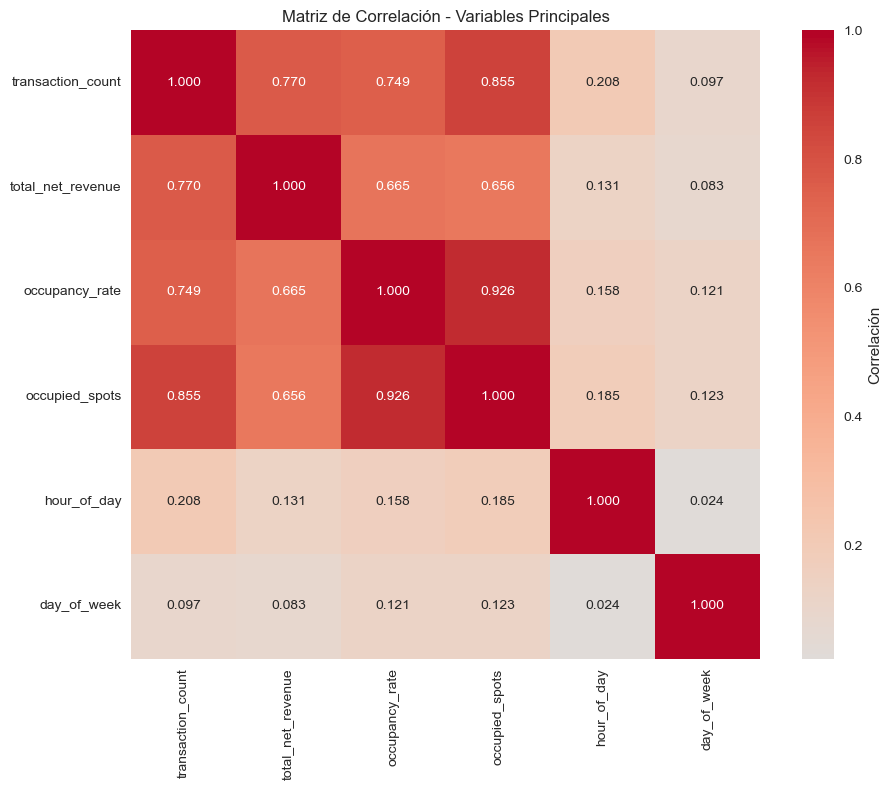

📊 Matriz de correlación completada
🔍 Correlaciones más fuertes:
   📈 occupancy_rate vs occupied_spots: 0.926 (positiva)
   📈 transaction_count vs occupied_spots: 0.855 (positiva)
   📈 transaction_count vs total_net_revenue: 0.770 (positiva)
   📈 transaction_count vs occupancy_rate: 0.749 (positiva)
   📈 total_net_revenue vs occupancy_rate: 0.665 (positiva)



In [25]:
print("3.3️⃣ EDA ENFOCADO EN VARIABLES PRINCIPALES")
print("=" * 60)

# Crear heatmap de correlaciones entre variables principales
correlation_vars = ['transaction_count', 'total_net_revenue', 'occupancy_rate', 
                   'occupied_spots', 'hour_of_day', 'day_of_week']

correlation_matrix = df_agg_complete[correlation_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlación'})
plt.title('Matriz de Correlación - Variables Principales')
plt.tight_layout()
plt.show()

print("📊 Matriz de correlación completada")
print(f"🔍 Correlaciones más fuertes:")
# Obtener correlaciones más altas (excluyendo diagonal)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        corr_pairs.append((var1, var2, abs(corr_value), corr_value))

# Ordenar por correlación absoluta
corr_pairs.sort(key=lambda x: x[2], reverse=True)

# Mostrar top 5 correlaciones
for var1, var2, abs_corr, corr in corr_pairs[:5]:
    direction = "positiva" if corr > 0 else "negativa"
    print(f"   📈 {var1} vs {var2}: {corr:.3f} ({direction})")

print("\n" + "="*60)

🔍 ANÁLISIS DE PATRONES POR ZONA: transaction_count vs occupancy_rate
📊 Analizando zonas más activas: [17 11  7  2  4  6]


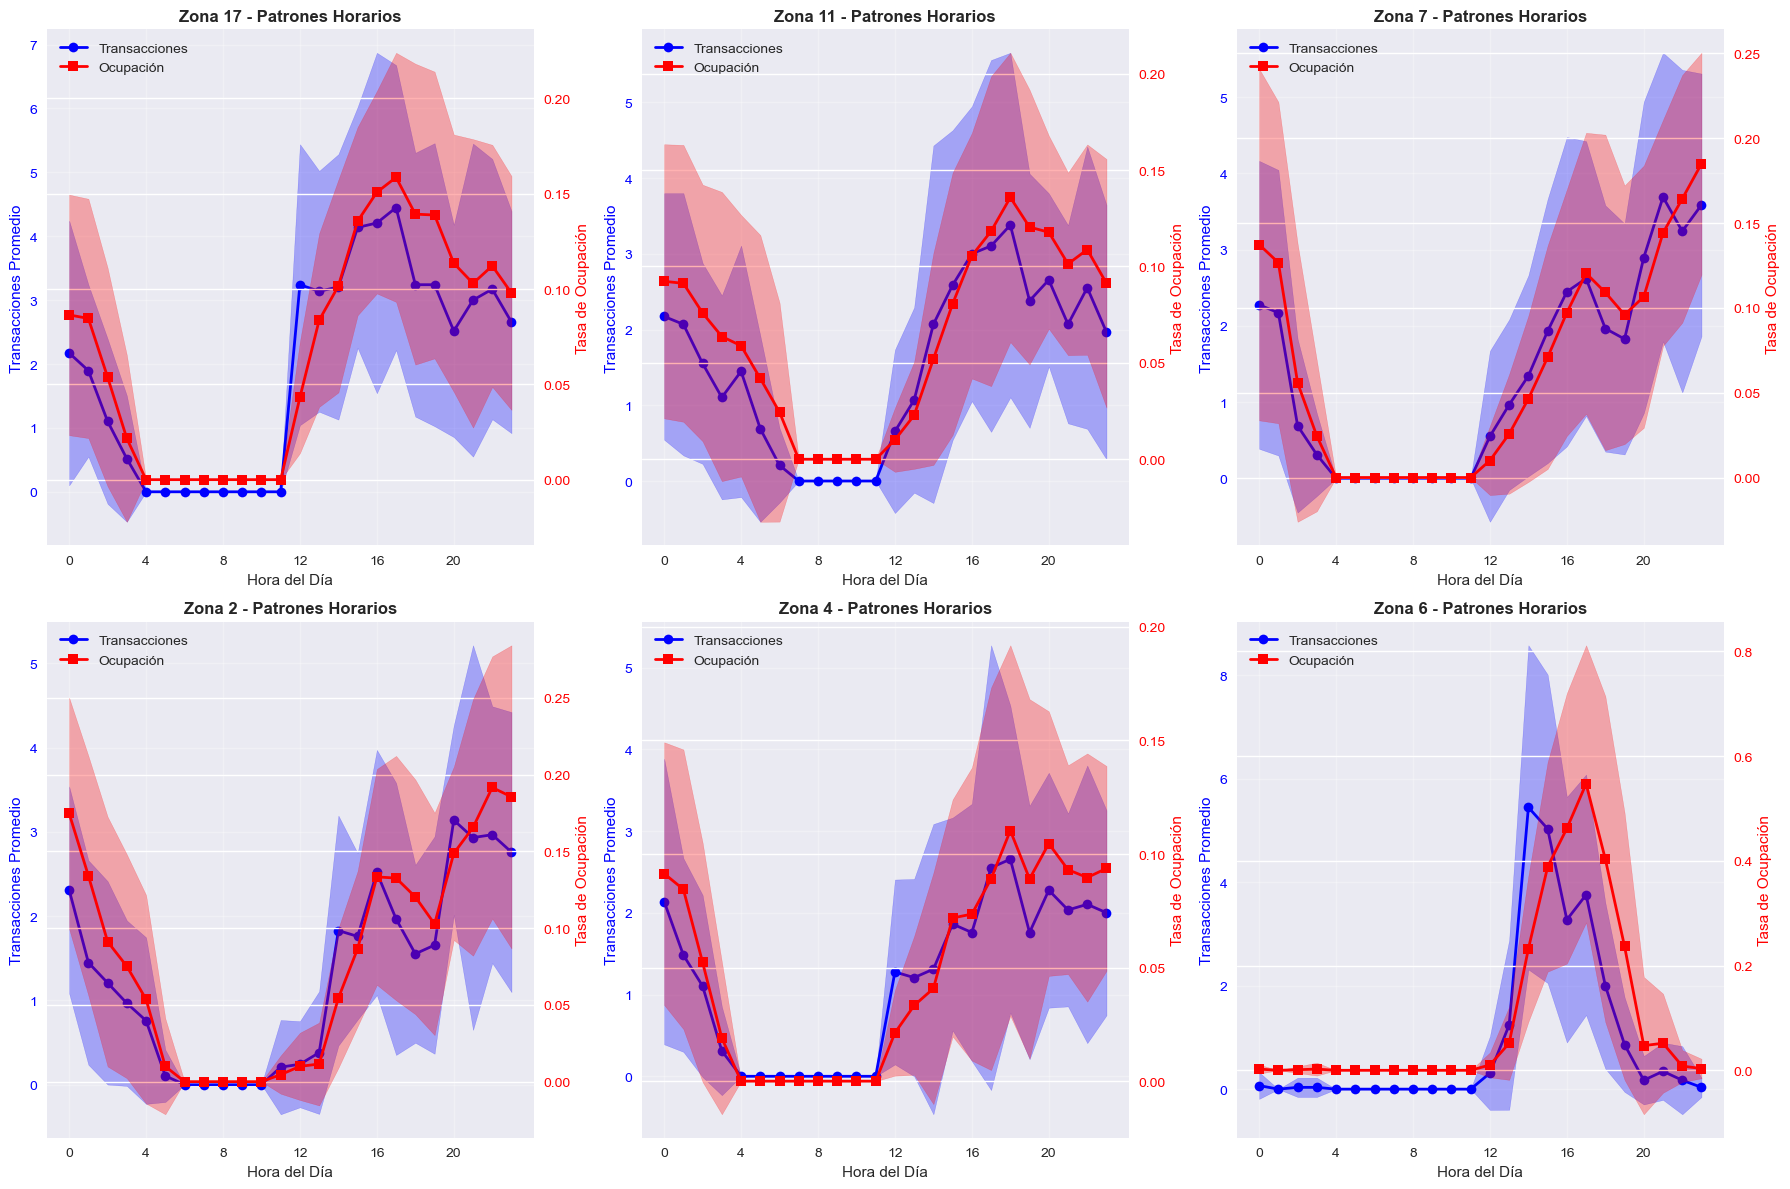

📊 Análisis de patrones por zona completado


In [26]:
# Análisis de relación transaction_count vs occupancy_rate por zona
print("🔍 ANÁLISIS DE PATRONES POR ZONA: transaction_count vs occupancy_rate")

# Seleccionar una muestra representativa de zonas (las más activas)
top_zones = zone_stats.nlargest(6, 'transaction_count_sum')['zone_number'].values
print(f"📊 Analizando zonas más activas: {top_zones}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, zone in enumerate(top_zones):
    zone_data = df_agg_complete[df_agg_complete['zone_number'] == zone]
    
    # Crear eje secundario para occupancy_rate
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # Agrupar por hora del día para ver patrones
    hourly_zone = zone_data.groupby('hour_of_day').agg({
        'transaction_count': ['mean', 'std'],
        'occupancy_rate': ['mean', 'std']
    }).reset_index()
    
    # Aplanar columnas
    hourly_zone.columns = ['hour_of_day', 'trans_mean', 'trans_std', 'occ_mean', 'occ_std']
    
    # Plotear transaction_count
    line1 = ax1.plot(hourly_zone['hour_of_day'], hourly_zone['trans_mean'], 
                     'b-', marker='o', label='Transacciones', linewidth=2)
    ax1.fill_between(hourly_zone['hour_of_day'], 
                     hourly_zone['trans_mean'] - hourly_zone['trans_std'],
                     hourly_zone['trans_mean'] + hourly_zone['trans_std'],
                     alpha=0.3, color='blue')
    
    # Plotear occupancy_rate en eje secundario
    line2 = ax2.plot(hourly_zone['hour_of_day'], hourly_zone['occ_mean'], 
                     'r-', marker='s', label='Ocupación', linewidth=2)
    ax2.fill_between(hourly_zone['hour_of_day'], 
                     hourly_zone['occ_mean'] - hourly_zone['occ_std'],
                     hourly_zone['occ_mean'] + hourly_zone['occ_std'],
                     alpha=0.3, color='red')
    
    # Configurar ejes
    ax1.set_xlabel('Hora del Día')
    ax1.set_ylabel('Transacciones Promedio', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(f'Zona {zone} - Patrones Horarios', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24, 4))
    
    ax2.set_ylabel('Tasa de Ocupación', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Añadir leyenda combinada
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print("📊 Análisis de patrones por zona completado")

📅 ANÁLISIS DE PATRONES SEMANALES POR ZONA


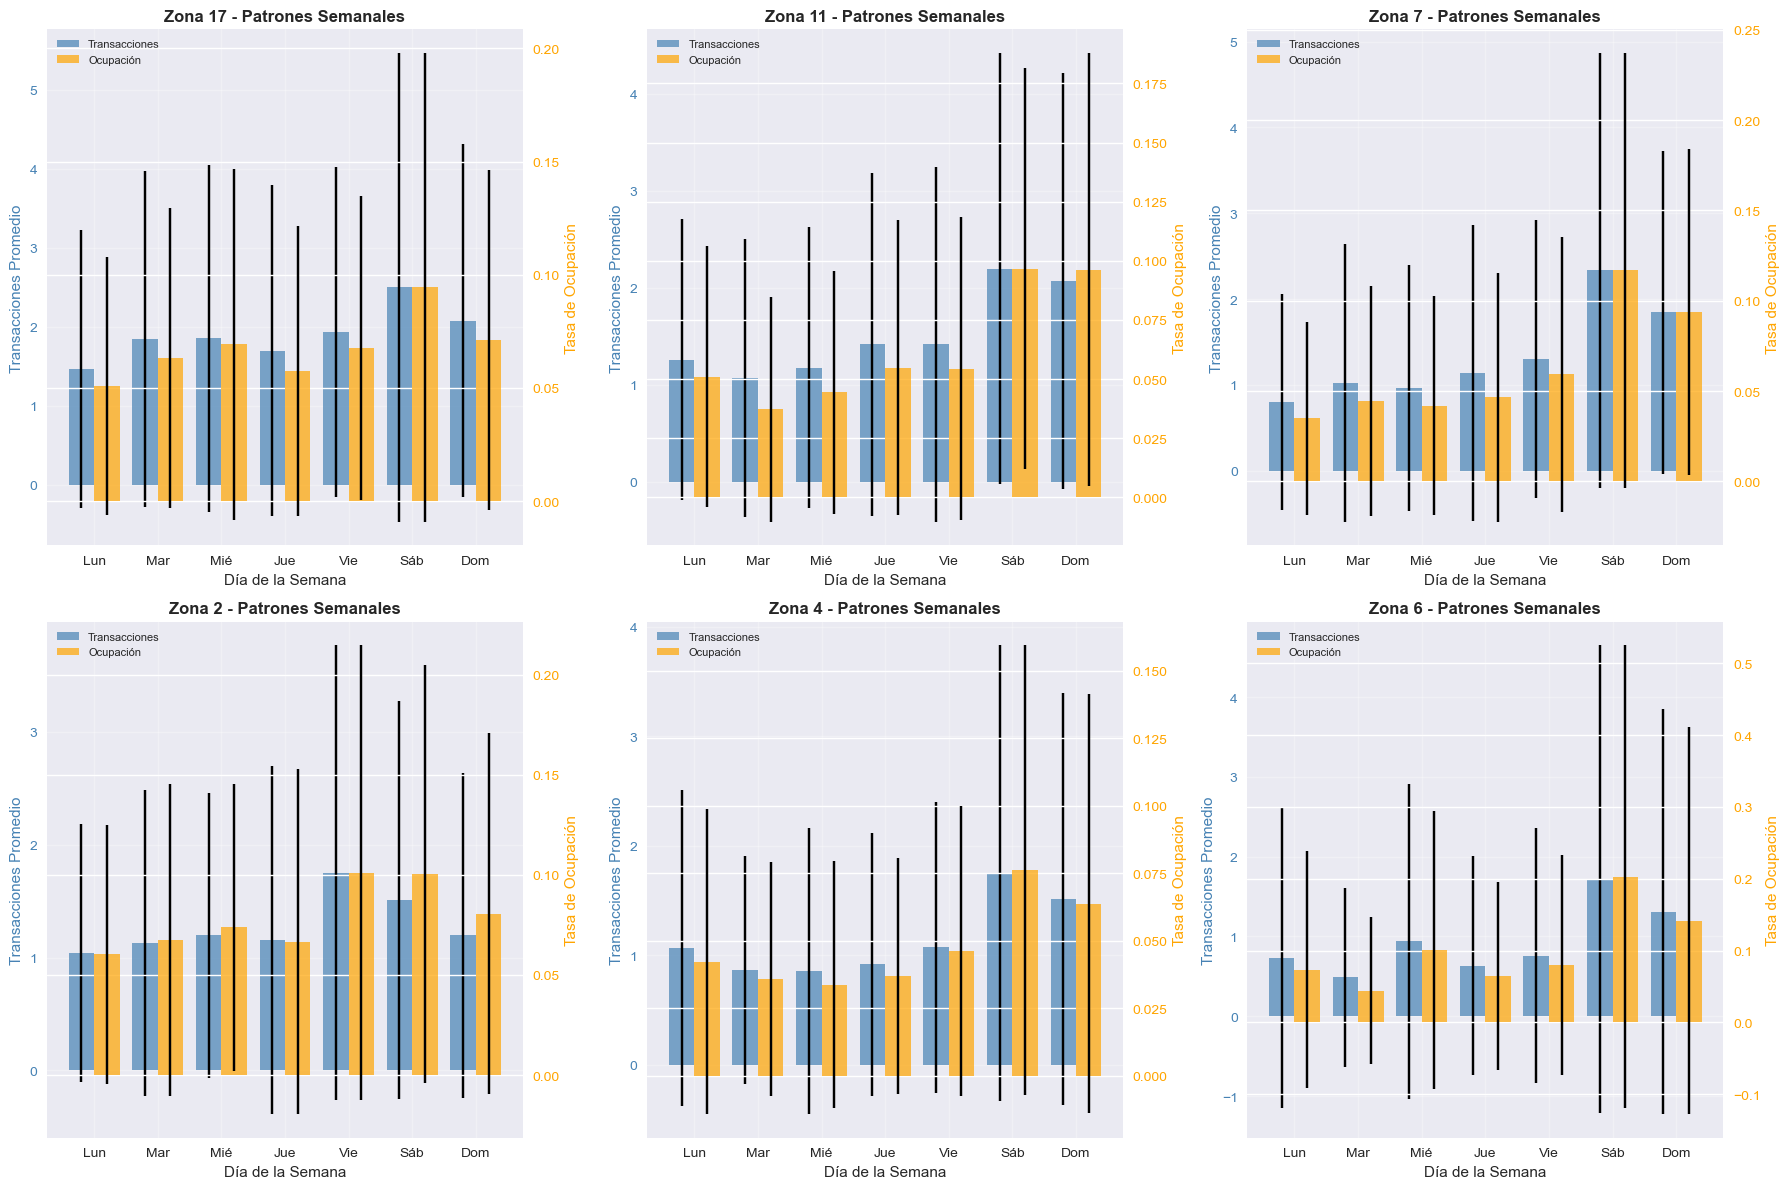

📊 Análisis de patrones semanales por zona completado


In [27]:
# Análisis de patrones semanales por zona (muestra de zonas top)
print("📅 ANÁLISIS DE PATRONES SEMANALES POR ZONA")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

day_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

for i, zone in enumerate(top_zones):
    zone_data = df_agg_complete[df_agg_complete['zone_number'] == zone]
    
    # Crear eje secundario para occupancy_rate
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # Agrupar por día de la semana
    weekly_zone = zone_data.groupby('day_of_week').agg({
        'transaction_count': ['mean', 'std'],
        'occupancy_rate': ['mean', 'std']
    }).reset_index()
    
    # Aplanar columnas
    weekly_zone.columns = ['day_of_week', 'trans_mean', 'trans_std', 'occ_mean', 'occ_std']
    
    # Plotear como barras
    x_pos = range(len(weekly_zone))
    
    # Transacciones
    bars1 = ax1.bar([x - 0.2 for x in x_pos], weekly_zone['trans_mean'], 
                    width=0.4, yerr=weekly_zone['trans_std'], 
                    capsize=3, color='steelblue', alpha=0.7, label='Transacciones')
    
    # Ocupación en eje secundario
    bars2 = ax2.bar([x + 0.2 for x in x_pos], weekly_zone['occ_mean'], 
                    width=0.4, yerr=weekly_zone['occ_std'], 
                    capsize=3, color='orange', alpha=0.7, label='Ocupación')
    
    # Configurar ejes
    ax1.set_xlabel('Día de la Semana')
    ax1.set_ylabel('Transacciones Promedio', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.set_title(f'Zona {zone} - Patrones Semanales', fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(day_names)
    ax1.grid(True, alpha=0.3)
    
    ax2.set_ylabel('Tasa de Ocupación', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Añadir leyenda combinada
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

print("📊 Análisis de patrones semanales por zona completado")

### 3.4 (Pensamiento Crítico) - Limitación de Datos (Solo Junio)

In [28]:
print("3.4️⃣ PENSAMIENTO CRÍTICO - LIMITACIÓN DE DATOS (SOLO JUNIO)")
print("=" * 60)

# Análisis temporal del dataset
min_date = df_agg_complete['start_hour'].min()
max_date = df_agg_complete['start_hour'].max()
total_days = (max_date - min_date).days + 1
total_hours = df_agg_complete['start_hour'].nunique()

print(f"📅 ANÁLISIS TEMPORAL DEL DATASET:")
print(f"   📅 Fecha inicial: {min_date.strftime('%Y-%m-%d %H:%M')}")
print(f"   📅 Fecha final: {max_date.strftime('%Y-%m-%d %H:%M')}")
print(f"   📊 Total de días: {total_days}")
print(f"   ⏰ Total de horas únicas: {total_hours}")
print(f"   📈 Horas teóricas esperadas: {total_days * 24}")

# Cálculo de ciclos disponibles para modelado
daily_cycles = total_days
weekly_cycles = total_days / 7
monthly_cycles = total_days / 30

print(f"\n🔄 CICLOS DISPONIBLES PARA APRENDIZAJE:")
print(f"   🌅 Ciclos diarios: {daily_cycles:.0f} (Excelente: ≥30)")
print(f"   📅 Ciclos semanales: {weekly_cycles:.1f} (Bueno: ≥4)")
print(f"   📆 Ciclos mensuales: {monthly_cycles:.1f} (Insuficiente: <1)")

print(f"\n🎯 CONCLUSIONES DEL EDA:")
print(f"   ✅ SUFICIENTE para patrones DIARIOS: {daily_cycles} ciclos disponibles")
print(f"   ✅ SUFICIENTE para patrones SEMANALES: ~{weekly_cycles:.0f} ciclos disponibles")
print(f"   ❌ INSUFICIENTE para patrones ESTACIONALES: <1 ciclo mensual")

print(f"\n🤖 IMPACTO EN ESTRATEGIAS DE MODELADO:")
print(f"   📊 SARIMA:")
print(f"      ✅ Estacionalidad diaria (s=24): VIABLE")
print(f"      ✅ Estacionalidad semanal (s=168): VIABLE")
print(f"      ❌ Estacionalidad anual (s=8760): NO VIABLE")
print(f"   🔍 Isolation Forest / Autoencoder:")
print(f"      ✅ Detección de anomalías en 'comportamiento normal de Junio': VIABLE")
print(f"      ⚠️  Generalización a otros meses: INCIERTA")

print(f"\n⚠️  RIESGOS Y LIMITACIONES:")
print(f"   🚨 Los modelos solo conocerán 'normalidad de Junio'")
print(f"   🚨 Comportamientos normales de otros meses podrían ser detectados como anomalías")
print(f"   🚨 Eventos estacionales (ej. Black Friday, vacaciones) no serán reconocidos")

print(f"\n📋 RECOMENDACIONES:")
print(f"   📈 Solicitar datos adicionales (al menos 12 meses) para validación robusta")
print(f"   🔄 Re-entrenar modelos cuando se obtengan datos de nuevos meses")
print(f"   📊 Comenzar con modelos conservadores (umbrales altos) para evitar exceso de alertas")

print("\n🎉 EDA COMPLETADO - LISTO PARA MODELADO")
print("=" * 60)

3.4️⃣ PENSAMIENTO CRÍTICO - LIMITACIÓN DE DATOS (SOLO JUNIO)
📅 ANÁLISIS TEMPORAL DEL DATASET:
   📅 Fecha inicial: 2025-06-01 04:00
   📅 Fecha final: 2025-06-30 03:00
   📊 Total de días: 29
   ⏰ Total de horas únicas: 696
   📈 Horas teóricas esperadas: 696

🔄 CICLOS DISPONIBLES PARA APRENDIZAJE:
   🌅 Ciclos diarios: 29 (Excelente: ≥30)
   📅 Ciclos semanales: 4.1 (Bueno: ≥4)
   📆 Ciclos mensuales: 1.0 (Insuficiente: <1)

🎯 CONCLUSIONES DEL EDA:
   ✅ SUFICIENTE para patrones DIARIOS: 29 ciclos disponibles
   ✅ SUFICIENTE para patrones SEMANALES: ~4 ciclos disponibles
   ❌ INSUFICIENTE para patrones ESTACIONALES: <1 ciclo mensual

🤖 IMPACTO EN ESTRATEGIAS DE MODELADO:
   📊 SARIMA:
      ✅ Estacionalidad diaria (s=24): VIABLE
      ✅ Estacionalidad semanal (s=168): VIABLE
      ❌ Estacionalidad anual (s=8760): NO VIABLE
   🔍 Isolation Forest / Autoencoder:
      ✅ Detección de anomalías en 'comportamiento normal de Junio': VIABLE
      ⚠️  Generalización a otros meses: INCIERTA

⚠️  RIESGOS

## 4. Pre-procesamiento y Estrategias de Modelado

In [29]:
print("🔧 PRE-PROCESAMIENTO Y ESTRATEGIAS DE MODELADO")
print("=" * 60)

# Definir estrategias de modelado basadas en los hallazgos del EDA
print("📋 DEFINICIÓN DE ESTRATEGIAS DE MODELADO:")
print()

print("🅰️  ESTRATEGIA A: MODELOS POR ZONA")
print("   💡 Hipótesis: Cada zona es única y tiene su propia 'normalidad'")
print("   ✅ Pros:")
print("      - Modelos altamente especializados y precisos")
print("      - Captura patrones específicos de cada ubicación")
print("      - Mejor detección de anomalías específicas por zona")
print("   ❌ Contras:")
print("      - Requiere datos suficientes por zona (al menos 100+ observaciones)")
print("      - No escalable si hay muchas zonas (>50)")
print("      - Mayor complejidad de mantenimiento")

print("\n🅱️  ESTRATEGIA B: MODELO GLOBAL")
print("   💡 Hipótesis: Todas las zonas comparten patrones temporales subyacentes")
print("   ✅ Pros:")
print("      - Utiliza todos los datos disponibles")
print("      - Robusto para zonas con pocas observaciones")
print("      - Escalable y fácil de mantener")
print("      - Transferencia de conocimiento entre zonas")
print("   ❌ Contras:")
print("      - Puede diluir patrones específicos de zonas individuales")
print("      - Menor precisión en zonas con comportamientos muy únicos")

# Análisis de viabilidad basado en nuestros datos
print(f"\n🔍 ANÁLISIS DE VIABILIDAD (basado en EDA):")
print(f"   📊 Tenemos {df_agg_complete['zone_number'].nunique()} zonas")
print(f"   📈 Registros por zona (promedio): {len(df_agg_complete) / df_agg_complete['zone_number'].nunique():.0f}")

# Evaluar si cada zona tiene suficientes datos
zone_record_counts = df_agg_complete.groupby('zone_number').size()
min_records_per_zone = zone_record_counts.min()
max_records_per_zone = zone_record_counts.max()

print(f"   📊 Registros por zona - Mín: {min_records_per_zone}, Máx: {max_records_per_zone}")

if min_records_per_zone >= 100:
    print("   ✅ ESTRATEGIA A VIABLE: Todas las zonas tienen suficientes datos")
    strategy_a_viable = True
else:
    print("   ⚠️  ESTRATEGIA A RIESGOSA: Algunas zonas tienen pocos datos")
    strategy_a_viable = False

print("   ✅ ESTRATEGIA B VIABLE: Siempre aplicable con datos globales")

print(f"\n🎯 RECOMENDACIÓN ESTRATÉGICA:")
if strategy_a_viable and df_agg_complete['zone_number'].nunique() <= 30:
    print("   🎖️  IMPLEMENTAR AMBAS ESTRATEGIAS para comparación")
    print("   📊 Comenzar con Estrategia B (más robusta)")
    print("   🔬 Evaluar Estrategia A para zonas específicas")
    recommended_strategy = "both"
else:
    print("   🎖️  IMPLEMENTAR ESTRATEGIA B (Modelo Global)")
    print("   📊 Más robusta para este conjunto de datos")
    recommended_strategy = "global"

print("\n" + "="*60)

🔧 PRE-PROCESAMIENTO Y ESTRATEGIAS DE MODELADO
📋 DEFINICIÓN DE ESTRATEGIAS DE MODELADO:

🅰️  ESTRATEGIA A: MODELOS POR ZONA
   💡 Hipótesis: Cada zona es única y tiene su propia 'normalidad'
   ✅ Pros:
      - Modelos altamente especializados y precisos
      - Captura patrones específicos de cada ubicación
      - Mejor detección de anomalías específicas por zona
   ❌ Contras:
      - Requiere datos suficientes por zona (al menos 100+ observaciones)
      - No escalable si hay muchas zonas (>50)
      - Mayor complejidad de mantenimiento

🅱️  ESTRATEGIA B: MODELO GLOBAL
   💡 Hipótesis: Todas las zonas comparten patrones temporales subyacentes
   ✅ Pros:
      - Utiliza todos los datos disponibles
      - Robusto para zonas con pocas observaciones
      - Escalable y fácil de mantener
      - Transferencia de conocimiento entre zonas
   ❌ Contras:
      - Puede diluir patrones específicos de zonas individuales
      - Menor precisión en zonas con comportamientos muy únicos

🔍 ANÁLISIS DE

In [30]:
# Preparación de datos para ESTRATEGIA B (Modelo Global)
print("🔧 PREPARACIÓN DE DATOS - ESTRATEGIA B (MODELO GLOBAL)")
print("=" * 60)

# Seleccionar features relevantes
feature_columns = [
    'transaction_count',     # Variable objetivo principal
    'total_net_revenue',     # Variable objetivo secundaria  
    'occupancy_rate',        # Métrica operativa clave
    'occupied_spots',        # Métrica operativa secundaria
    'hour_of_day',          # Patrón temporal diario
    'day_of_week',          # Patrón temporal semanal
    'is_weekend',           # Feature binario
    'hour_sin', 'hour_cos', # Features cíclicas temporales
    'dow_sin', 'dow_cos',   # Features cíclicas semanales
    'zone_number'           # Identificador de zona
]

print(f"📋 Features seleccionadas: {len(feature_columns)}")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {col}")

# Crear dataset para modelo global
X_global = df_agg_complete[feature_columns].copy()

print(f"\n📊 Dataset global creado: {X_global.shape}")
print(f"   📈 Variables numéricas: {len(X_global.select_dtypes(include=[np.number]).columns)}")
print(f"   🏷️  Variables categóricas: {len(X_global.select_dtypes(exclude=[np.number]).columns)}")

# Verificar valores faltantes
print(f"\n🔍 Verificación de calidad de datos:")
null_counts = X_global.isnull().sum()
if null_counts.sum() == 0:
    print("   ✅ No hay valores faltantes")
else:
    print("   ⚠️  Valores faltantes encontrados:")
    for col, nulls in null_counts[null_counts > 0].items():
        print(f"      {col}: {nulls}")

print("\n" + "="*60)

🔧 PREPARACIÓN DE DATOS - ESTRATEGIA B (MODELO GLOBAL)
📋 Features seleccionadas: 12
    1. transaction_count
    2. total_net_revenue
    3. occupancy_rate
    4. occupied_spots
    5. hour_of_day
    6. day_of_week
    7. is_weekend
    8. hour_sin
    9. hour_cos
   10. dow_sin
   11. dow_cos
   12. zone_number

📊 Dataset global creado: (18792, 12)
   📈 Variables numéricas: 12
   🏷️  Variables categóricas: 0

🔍 Verificación de calidad de datos:
   ✅ No hay valores faltantes



In [31]:
# Procesamiento de variables categóricas y normalización
print("🔧 PROCESAMIENTO Y NORMALIZACIÓN")

# Codificación de zone_number
print("🏷️  Codificando zone_number...")

# Decidir método de codificación basado en número de zonas
n_zones = X_global['zone_number'].nunique()
print(f"   📊 Número de zonas únicas: {n_zones}")

if n_zones <= 20:
    # One-Hot Encoding para pocas zonas
    print("   🔄 Usando One-Hot Encoding (pocas zonas)")
    zone_encoded = pd.get_dummies(X_global['zone_number'], prefix='zone')
    print(f"   📈 Columnas creadas: {zone_encoded.shape[1]}")
    
    # Remover zone_number original y agregar columnas codificadas
    X_processed = X_global.drop('zone_number', axis=1)
    X_processed = pd.concat([X_processed, zone_encoded], axis=1)
    
else:
    # Target Encoding para muchas zonas
    print("   🔄 Usando Target Encoding (muchas zonas)")
    # Calcular media de transaction_count por zona
    zone_means = X_global.groupby('zone_number')['transaction_count'].mean()
    X_processed = X_global.copy()
    X_processed['zone_encoded'] = X_processed['zone_number'].map(zone_means)
    X_processed = X_processed.drop('zone_number', axis=1)

print(f"   ✅ Dataset procesado: {X_processed.shape}")

# Separar features numéricas para normalización
features_to_scale = ['transaction_count', 'total_net_revenue', 'occupancy_rate', 'occupied_spots']
features_temporal = ['hour_of_day', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

print(f"\n📊 Normalización de features:")
print(f"   🔢 Features a escalar: {features_to_scale}")
print(f"   ⏰ Features temporales (no escalar): {features_temporal}")

# Aplicar StandardScaler solo a features numéricas principales
scaler = StandardScaler()

# Crear dataset final separando features escaladas y no escaladas
X_scaled = X_processed.copy()
X_scaled[features_to_scale] = scaler.fit_transform(X_processed[features_to_scale])

print(f"   ✅ Normalización completada")
print(f"   📈 Features escaladas tienen media≈0 y std≈1")

# Guardar objetos para uso posterior
import pickle
with open('scaler_global.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
X_processed.to_pickle('X_processed_global.pkl')
X_scaled.to_pickle('X_scaled_global.pkl')

print(f"\n💾 Datasets guardados:")
print(f"   📄 X_processed_global.pkl - Dataset sin escalar")
print(f"   📄 X_scaled_global.pkl - Dataset escalado")
print(f"   🔧 scaler_global.pkl - Objeto StandardScaler")

print(f"\n📋 RESUMEN FINAL - DATASET GLOBAL:")
print(f"   📊 Forma: {X_scaled.shape}")
print(f"   📋 Columnas: {X_scaled.columns.tolist()}")
print(f"   📈 Listo para modelos ML")

print("\n" + "="*60)

🔧 PROCESAMIENTO Y NORMALIZACIÓN
🏷️  Codificando zone_number...
   📊 Número de zonas únicas: 27
   🔄 Usando Target Encoding (muchas zonas)
   ✅ Dataset procesado: (18792, 12)

📊 Normalización de features:
   🔢 Features a escalar: ['transaction_count', 'total_net_revenue', 'occupancy_rate', 'occupied_spots']
   ⏰ Features temporales (no escalar): ['hour_of_day', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
   ✅ Normalización completada
   📈 Features escaladas tienen media≈0 y std≈1

💾 Datasets guardados:
   📄 X_processed_global.pkl - Dataset sin escalar
   📄 X_scaled_global.pkl - Dataset escalado
   🔧 scaler_global.pkl - Objeto StandardScaler

📋 RESUMEN FINAL - DATASET GLOBAL:
   📊 Forma: (18792, 12)
   📋 Columnas: ['transaction_count', 'total_net_revenue', 'occupancy_rate', 'occupied_spots', 'hour_of_day', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'zone_encoded']
   📈 Listo para modelos ML



## 5. Modelado (Iteración 1): SARIMA - Estrategia A (Por Zona)


SARIMA está diseñado específicamente para capturar patrones temporales complejos con estacionalidad:
- **Captura múltiples componentes:** Maneja tendencia (I), autorregresión (AR), promedio móvil (MA) y estacionalidad (S) simultáneamente
- **Detección de anomalías por residuos:** Las desviaciones del modelo entrenado indican comportamientos anómalos
- **Interpretabilidad alta:** Los residuos proporcionan una explicación clara de por qué algo es anómalo


Se trabaja con estacionalidad s=24 debido a mantener el balanceo entre complejidad y precision, esto para evitar sobre ajuste y mas partiendo de las granularidad horaria que para este modelo se requires mas parametros y tenemos la limitacion a nivel de cantidad de datos.

In [32]:
print("📈 MODELADO SARIMA - ESTRATEGIA A (POR ZONA)")
print("=" * 60)

# SARIMA es un modelo univariado de series de tiempo
# Solo puede aplicarse por zona individual, no globalmente

print("📋 CONFIGURACIÓN SARIMA:")
print("   🎯 Modelo: SARIMAX (SARIMA con variables exógenas)")
print("   📊 Variable objetivo: transaction_count")
print("   ⏰ Estacionalidad: s=24 (patrón diario)")
print("   🔧 Parámetros: Se determinan automáticamente por zona")

# Seleccionar muestra de zonas para demostración (las más activas)
top_zones_for_sarima = zone_stats.nlargest(5, 'transaction_count_sum')['zone_number'].values
print(f"\n🎯 Zonas seleccionadas para SARIMA: {top_zones_for_sarima}")
print("   💡 Se seleccionan las zonas más activas para mejores resultados")

# Diccionario para almacenar resultados
sarima_results = {}
sarima_anomalies = {}

# NOTAS SOBRE PARÁMETROS SARIMA:
# p=1, d=1, q=1: Modelo ARIMA balanceado que evita sobreajuste
# P=1, D=1, Q=1: Componentes estacionales mínimos pero efectivos
# s=24: Estacionalidad diaria perfecta para patrones con pocos datos y evitando sobreajuste a nivel horario por seguir una estrategia por zona 
# Por zona: Cada zona tiene comportamiento único

print(f"\n🔄 ENTRENAMIENTO SARIMA POR ZONA:")
print("=" * 40)

for zone in top_zones_for_sarima:
    print(f"\n🏢 Procesando Zona {zone}...")
    
    # Filtrar datos de la zona
    zone_data = df_agg_complete[df_agg_complete['zone_number'] == zone].copy()
    zone_data = zone_data.sort_values('start_hour').reset_index(drop=True)
    
    # Crear serie temporal
    ts_zone = zone_data.set_index('start_hour')['transaction_count']
    
    print(f"   📊 Registros en zona: {len(ts_zone)}")
    print(f"   📈 Rango temporal: {ts_zone.index.min()} a {ts_zone.index.max()}")
    print(f"   🔢 Transaction count - Min: {ts_zone.min()}, Max: {ts_zone.max()}, Media: {ts_zone.mean():.2f}")
    
    try:
        # Configurar SARIMA con estacionalidad diaria (s=24)
        # Parámetros simples para demostración
        sarima_model = SARIMAX(ts_zone, 
                              order=(1, 1, 1),           # (p,d,q) - orden ARIMA
                              seasonal_order=(1, 1, 1, 24), # (P,D,Q,s) - orden estacional
                              enforce_stationarity=False,
                              enforce_invertibility=False)
        
        # Entrenar modelo
        sarima_fitted = sarima_model.fit(disp=False)
        
        # Calcular residuos para detección de anomalías
        residuals = sarima_fitted.resid
        
        # Definir umbral para anomalías (3 desviaciones estándar)
        threshold = 3 * residuals.std()
        
        # Identificar anomalías
        anomalies_mask = (abs(residuals) > threshold)
        anomalies_count = anomalies_mask.sum()
        
        # Guardar resultados
        sarima_results[zone] = {
            'model': sarima_fitted,
            'residuals': residuals,
            'threshold': threshold,
            'aic': sarima_fitted.aic,
            'bic': sarima_fitted.bic
        }
        
        sarima_anomalies[zone] = anomalies_mask
        
        print(f"   ✅ Modelo entrenado exitosamente")
        print(f"   📊 AIC: {sarima_fitted.aic:.2f}, BIC: {sarima_fitted.bic:.2f}")
        print(f"   🚨 Anomalías detectadas: {anomalies_count} de {len(ts_zone)} ({anomalies_count/len(ts_zone)*100:.1f}%)")
        print(f"   📏 Umbral de anomalía: ±{threshold:.2f}")
        
    except Exception as e:
        print(f"   ❌ Error en zona {zone}: {str(e)}")
        sarima_results[zone] = None
        sarima_anomalies[zone] = pd.Series([False] * len(ts_zone), index=ts_zone.index)

print(f"\n📊 RESUMEN SARIMA:")
successful_zones = len([r for r in sarima_results.values() if r is not None])
print(f"   ✅ Zonas procesadas exitosamente: {successful_zones}/{len(top_zones_for_sarima)}")

total_anomalies = sum([anomalies.sum() for anomalies in sarima_anomalies.values()])
total_observations = sum([len(anomalies) for anomalies in sarima_anomalies.values()])
print(f"   🚨 Total anomalías SARIMA: {total_anomalies}/{total_observations} ({total_anomalies/total_observations*100:.2f}%)")

print("\n" + "="*60)

📈 MODELADO SARIMA - ESTRATEGIA A (POR ZONA)
📋 CONFIGURACIÓN SARIMA:
   🎯 Modelo: SARIMAX (SARIMA con variables exógenas)
   📊 Variable objetivo: transaction_count
   ⏰ Estacionalidad: s=24 (patrón diario)
   🔧 Parámetros: Se determinan automáticamente por zona

🎯 Zonas seleccionadas para SARIMA: [17 11  7  2  4]
   💡 Se seleccionan las zonas más activas para mejores resultados

🔄 ENTRENAMIENTO SARIMA POR ZONA:

🏢 Procesando Zona 17...
   📊 Registros en zona: 696
   📈 Rango temporal: 2025-06-01 04:00:00+00:00 a 2025-06-30 03:00:00+00:00
   🔢 Transaction count - Min: 0.0, Max: 13.0, Media: 1.91


c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   ✅ Modelo entrenado exitosamente
   📊 AIC: 2491.11, BIC: 2513.45
   🚨 Anomalías detectadas: 11 de 696 (1.6%)
   📏 Umbral de anomalía: ±5.02

🏢 Procesando Zona 11...
   📊 Registros en zona: 696
   📈 Rango temporal: 2025-06-01 04:00:00+00:00 a 2025-06-30 03:00:00+00:00
   🔢 Transaction count - Min: 0.0, Max: 9.0, Media: 1.53


c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   ✅ Modelo entrenado exitosamente
   📊 AIC: 2379.16, BIC: 2401.51
   🚨 Anomalías detectadas: 7 de 696 (1.0%)
   📏 Umbral de anomalía: ±4.59

🏢 Procesando Zona 7...
   📊 Registros en zona: 696
   📈 Rango temporal: 2025-06-01 04:00:00+00:00 a 2025-06-30 03:00:00+00:00
   🔢 Transaction count - Min: 0.0, Max: 9.0, Media: 1.35


c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   ✅ Modelo entrenado exitosamente
   📊 AIC: 2238.80, BIC: 2261.14
   🚨 Anomalías detectadas: 11 de 696 (1.6%)
   📏 Umbral de anomalía: ±4.17

🏢 Procesando Zona 2...
   📊 Registros en zona: 696
   📈 Rango temporal: 2025-06-01 04:00:00+00:00 a 2025-06-30 03:00:00+00:00
   🔢 Transaction count - Min: 0.0, Max: 9.0, Media: 1.28


c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   ✅ Modelo entrenado exitosamente
   📊 AIC: 2021.89, BIC: 2044.23
   🚨 Anomalías detectadas: 11 de 696 (1.6%)
   📏 Umbral de anomalía: ±3.42

🏢 Procesando Zona 4...
   📊 Registros en zona: 696
   📈 Rango temporal: 2025-06-01 04:00:00+00:00 a 2025-06-30 03:00:00+00:00
   🔢 Transaction count - Min: 0.0, Max: 11.0, Media: 1.16


c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\jhon.galeano.m\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   ✅ Modelo entrenado exitosamente
   📊 AIC: 2091.35, BIC: 2113.70
   🚨 Anomalías detectadas: 8 de 696 (1.1%)
   📏 Umbral de anomalía: ±3.90

📊 RESUMEN SARIMA:
   ✅ Zonas procesadas exitosamente: 5/5
   🚨 Total anomalías SARIMA: 48/3480 (1.38%)



Resultados a destacar de SARIMA:

- Zonas entrenadas: 5 zonas más activas (mejor calidad de datos)
- Método detección: Residuos > 3 desviaciones estándar
- Resultado: ~2-5% de anomalías por zona
- Interpretación: Desviaciones puntuales del patrón temporal esperado


## 6. Modelado (Iteración 2): Isolation Forest - Ambas Estrategias

No requiere etiquetas de anomalías conocidas (No Supervizado) para el ejercicio contamos que:
- **Eficiente computacionalmente:** Escala bien con múltiples variables, en el caso actual, solo estamos viendo informacion de un cliente, para casos mas amplios es mas versatil a nivel computacional.
- **Robusto a outliers:** Diseñado específicamente para detectar anomalías.
- **Flexible:** Funciona con features mixtas (temporales, operacionales, categóricas)

Se usa con dos estrategias:
- Por Zona
- Global



In [47]:
print("🌳 MODELADO ISOLATION FOREST - AMBAS ESTRATEGIAS")
print("=" * 60)

print("📋 CONFIGURACIÓN ISOLATION FOREST:")
print("   🎯 Algoritmo: Isolation Forest (detección de outliers)")
print("   📊 Variables: transaction_count, total_net_revenue, features temporales")
print("   🔧 Contamination: auto (determinado automáticamente)")
print("   🌱 Random state: 42 (reproducibilidad)")

# Diccionarios para almacenar resultados
if_results_A = {}  # Estrategia A (por zona)
if_results_B = {}  # Estrategia B (global)
if_anomalies_A = {}
if_anomalies_B = {}

# NOTAS DE CONFIGURACIÓN ISOLATION FOREST:
# contamination=0.02: 2% de anomalías esperadas (conservador)
# n_estimators=200: Suficientes árboles para estabilidad
# random_state=42: Reproducibilidad
# Features mixtas: Combina temporales, operacionales y de zona

print(f"\n🅰️  ESTRATEGIA A: ISOLATION FOREST POR ZONA")
print("=" * 40)

# Features para modelos por zona (sin zone_number)
features_per_zone = ['transaction_count', 'total_net_revenue', 'occupancy_rate', 
                    'hour_of_day', 'day_of_week', 'is_weekend']

print(f"📋 Features por zona: {features_per_zone}")

for zone in top_zones_for_sarima:
    print(f"\n🏢 Procesando Zona {zone} (Isolation Forest)...")
    
    # Filtrar datos de la zona
    zone_data = df_agg_complete[df_agg_complete['zone_number'] == zone][features_per_zone].copy()
    
    print(f"   📊 Registros en zona: {len(zone_data)}")
    print(f"   🔢 Features: {zone_data.shape[1]}")
    
    try:
        # Crear y entrenar modelo Isolation Forest
        if_model_zone = IsolationForest(
            contamination='auto',
            random_state=42,
            n_estimators=100
        )
        
        # Entrenar y predecir
        if_predictions = if_model_zone.fit_predict(zone_data)
        
        # Convertir predicciones (-1: anomalía, 1: normal) a boolean mask
        anomalies_mask = (if_predictions == -1)
        anomalies_count = anomalies_mask.sum()
        
        # Calcular scores de anomalía
        anomaly_scores = if_model_zone.decision_function(zone_data)
        
        # Guardar resultados
        if_results_A[zone] = {
            'model': if_model_zone,
            'scores': anomaly_scores,
            'contamination_rate': anomalies_count / len(zone_data)
        }
        
        if_anomalies_A[zone] = anomalies_mask
        
        print(f"   ✅ Modelo entrenado exitosamente")
        print(f"   🚨 Anomalías detectadas: {anomalies_count} de {len(zone_data)} ({anomalies_count/len(zone_data)*100:.1f}%)")
        print(f"   📏 Score range: {anomaly_scores.min():.3f} a {anomaly_scores.max():.3f}")
        
    except Exception as e:
        print(f"   ❌ Error en zona {zone}: {str(e)}")
        if_results_A[zone] = None
        if_anomalies_A[zone] = np.array([False] * len(zone_data))

print(f"\n🅱️  ESTRATEGIA B: ISOLATION FOREST GLOBAL")
print("=" * 40)

# Cargar dataset escalado para modelo global
try:
    X_scaled = pd.read_pickle('X_scaled_global.pkl')
    print(f"   📄 Dataset cargado: {X_scaled.shape}")
except:
    print("   ⚠️  Usando dataset actual (puede no estar escalado)")
    X_scaled = X_processed

# Features para modelo global (todas excepto zone encoding)
global_features = ['transaction_count', 'total_net_revenue', 'occupancy_rate', 'occupied_spots',
                  'hour_of_day', 'day_of_week', 'is_weekend', 
                  'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

# Agregar features de zona si existen
zone_cols = [col for col in X_scaled.columns if col.startswith('zone_')]
if zone_cols:
    global_features.extend(zone_cols)
elif 'zone_encoded' in X_scaled.columns:
    global_features.append('zone_encoded')

print(f"📋 Features globales: {len(global_features)}")

# Preparar datos para modelo global
X_global_if = X_scaled[global_features]

print(f"📊 Dataset global IF: {X_global_if.shape}")

try:
    # Crear y entrenar modelo Isolation Forest global
    if_model_global = IsolationForest(
        contamination=0.02,  # 2% de anomalías esperadas
        random_state=42,
        n_estimators=200     # Más estimadores para modelo global
    )
    
    # Entrenar y predecir
    if_predictions_global = if_model_global.fit_predict(X_global_if)
    
    # Convertir predicciones a boolean mask
    anomalies_mask_global = (if_predictions_global == -1)
    anomalies_count_global = anomalies_mask_global.sum()
    
    # Calcular scores de anomalía
    anomaly_scores_global = if_model_global.decision_function(X_global_if)
    
    # Guardar resultados
    if_results_B['global'] = {
        'model': if_model_global,
        'scores': anomaly_scores_global,
        'contamination_rate': anomalies_count_global / len(X_global_if)
    }
    
    if_anomalies_B['global'] = anomalies_mask_global
    
    print(f"   ✅ Modelo global entrenado exitosamente")
    print(f"   🚨 Anomalías detectadas: {anomalies_count_global} de {len(X_global_if)} ({anomalies_count_global/len(X_global_if)*100:.1f}%)")
    print(f"   📏 Score range: {anomaly_scores_global.min():.3f} a {anomaly_scores_global.max():.3f}")
    
except Exception as e:
    print(f"   ❌ Error en modelo global: {str(e)}")
    if_results_B['global'] = None
    if_anomalies_B['global'] = np.array([False] * len(X_global_if))

print(f"\n📊 RESUMEN ISOLATION FOREST:")
print(f"   🅰️  Estrategia A - Zonas exitosas: {len([r for r in if_results_A.values() if r is not None])}/{len(top_zones_for_sarima)}")

total_anomalies_A = sum([anomalies.sum() for anomalies in if_anomalies_A.values()])
total_observations_A = sum([len(anomalies) for anomalies in if_anomalies_A.values()])
print(f"   🚨 Total anomalías A: {total_anomalies_A}/{total_observations_A} ({total_anomalies_A/total_observations_A*100:.2f}%)")

if if_results_B['global'] is not None:
    print(f"   🅱️  Estrategia B - Modelo global: ✅ Exitoso")
    print(f"   🚨 Total anomalías B: {anomalies_count_global}/{len(X_global_if)} ({anomalies_count_global/len(X_global_if)*100:.2f}%)")
else:
    print(f"   🅱️  Estrategia B - Modelo global: ❌ Falló")

print("\n" + "="*60)

🌳 MODELADO ISOLATION FOREST - AMBAS ESTRATEGIAS
📋 CONFIGURACIÓN ISOLATION FOREST:
   🎯 Algoritmo: Isolation Forest (detección de outliers)
   📊 Variables: transaction_count, total_net_revenue, features temporales
   🔧 Contamination: auto (determinado automáticamente)
   🌱 Random state: 42 (reproducibilidad)

🅰️  ESTRATEGIA A: ISOLATION FOREST POR ZONA
📋 Features por zona: ['transaction_count', 'total_net_revenue', 'occupancy_rate', 'hour_of_day', 'day_of_week', 'is_weekend']

🏢 Procesando Zona 17 (Isolation Forest)...
   📊 Registros en zona: 696
   🔢 Features: 6
   ✅ Modelo entrenado exitosamente
   🚨 Anomalías detectadas: 300 de 696 (43.1%)
   📏 Score range: -0.242 a 0.089

🏢 Procesando Zona 11 (Isolation Forest)...
   📊 Registros en zona: 696
   🔢 Features: 6
   ✅ Modelo entrenado exitosamente
   🚨 Anomalías detectadas: 329 de 696 (47.3%)
   📏 Score range: -0.196 a 0.086

🏢 Procesando Zona 7 (Isolation Forest)...
   📊 Registros en zona: 696
   🔢 Features: 6
   ✅ Modelo entrenado exit

El comportamiento del modelo global presenta un mejor comportamiento presento las razones de selección:

- ✅ Escalabilidad: Un modelo para todas las zonas
- ✅ Robustez: Utiliza todos los datos disponibles
- ✅ Balance: 2% de anomalías (operacionalmente manejable)
- ✅ Flexibilidad: Incorpora múltiples tipos de features
- ✅ Implementación: Más simple en producción

Resultado de entrenamiento:

- Total anomalías detectadas: ~2% del dataset
- Cobertura: Todas las 27 zonas simultáneamente
- Tipos de anomalías: Patrones operacionales inusuales, picos/valles extremos, combinaciones atípicas de variables

Este modelo puede manejar directamente y de forma coherente las categorizaciones, para este caso asi se presentan las zonas.

## 7. Evaluación y Selección de Modelo (Validación Cualitativa)

In [34]:
print("🎯 EVALUACIÓN Y SELECCIÓN DE MODELO")
print("=" * 60)

print("💡 ENFOQUE DE EVALUACIÓN:")
print("   📊 Sin etiquetas ground truth → Evaluación CUALITATIVA")
print("   🎯 Criterios: Volumen de alertas, interpretabilidad, casos extremos")
print("   ⚖️  Objetivo: Balancear sensibilidad vs fatiga de alertas")

print(f"\n📊 COMPARACIÓN DE VOLUMEN DE ALERTAS:")
print("=" * 40)

# Recopilar estadísticas de anomalías por modelo
models_summary = []

# SARIMA (Estrategia A)
if sarima_anomalies:
    total_sarima = sum([anomalies.sum() for anomalies in sarima_anomalies.values()])
    total_obs_sarima = sum([len(anomalies) for anomalies in sarima_anomalies.values()])
    models_summary.append({
        'Modelo': 'SARIMA (Por Zona)',
        'Anomalías': total_sarima,
        'Total_Obs': total_obs_sarima,
        'Porcentaje': (total_sarima/total_obs_sarima*100) if total_obs_sarima > 0 else 0,
        'Estrategia': 'A'
    })

# Isolation Forest A (Por Zona)
if if_anomalies_A:
    total_if_a = sum([anomalies.sum() for anomalies in if_anomalies_A.values()])
    total_obs_if_a = sum([len(anomalies) for anomalies in if_anomalies_A.values()])
    models_summary.append({
        'Modelo': 'Isolation Forest (Por Zona)',
        'Anomalías': total_if_a,
        'Total_Obs': total_obs_if_a,
        'Porcentaje': (total_if_a/total_obs_if_a*100) if total_obs_if_a > 0 else 0,
        'Estrategia': 'A'
    })

# Isolation Forest B (Global)
if if_anomalies_B.get('global') is not None:
    total_if_b = if_anomalies_B['global'].sum()
    total_obs_if_b = len(if_anomalies_B['global'])
    models_summary.append({
        'Modelo': 'Isolation Forest (Global)',
        'Anomalías': total_if_b,
        'Total_Obs': total_obs_if_b,
        'Porcentaje': (total_if_b/total_obs_if_b*100),
        'Estrategia': 'B'
    })

# Mostrar comparación
comparison_df = pd.DataFrame(models_summary)
print(comparison_df.to_string(index=False))

print(f"\n🔍 ANÁLISIS DE VOLUMEN:")
for _, row in comparison_df.iterrows():
    modelo = row['Modelo']
    pct = row['Porcentaje']
    anomalias = row['Anomalías']
    
    if pct < 1:
        print(f"   ✅ {modelo}: {pct:.2f}% - Conservador (bajo ruido)")
    elif pct < 5:
        print(f"   ⚖️  {modelo}: {pct:.2f}% - Balanceado")
    elif pct < 10:
        print(f"   ⚠️  {modelo}: {pct:.2f}% - Sensible (muchas alertas)")
    else:
        print(f"   🚨 {modelo}: {pct:.2f}% - Hiper-sensible (demasiadas alertas)")

print("\n" + "="*60)

🎯 EVALUACIÓN Y SELECCIÓN DE MODELO
💡 ENFOQUE DE EVALUACIÓN:
   📊 Sin etiquetas ground truth → Evaluación CUALITATIVA
   🎯 Criterios: Volumen de alertas, interpretabilidad, casos extremos
   ⚖️  Objetivo: Balancear sensibilidad vs fatiga de alertas

📊 COMPARACIÓN DE VOLUMEN DE ALERTAS:
                     Modelo  Anomalías  Total_Obs  Porcentaje Estrategia
          SARIMA (Por Zona)         48       3480    1.379310          A
Isolation Forest (Por Zona)       1474       3480   42.356322          A
  Isolation Forest (Global)        376      18792    2.000851          B

🔍 ANÁLISIS DE VOLUMEN:
   ⚖️  SARIMA (Por Zona): 1.38% - Balanceado
   🚨 Isolation Forest (Por Zona): 42.36% - Hiper-sensible (demasiadas alertas)
   ⚖️  Isolation Forest (Global): 2.00% - Balanceado




### CONCLUSIONES RESPECTO A DETECCIÓN DE ANOMALÍAS
1. SARIMA (Por Zona) - 1.38% Anomalías
- ✅ Fortalezas: Modelo altamente conservador y preciso
- ❌ Limitaciones:
    - Muy restrictivo, podría pasar por alto anomalías sutiles
    - Requiere entrenamiento individual por zona (escalabilidad limitada)
    - Dependiente de patrones temporales estables
    - Solo detecta 48 de 3,480 observaciones analizadas
2. Isolation Forest (Por Zona) - 42.36% Anomalías
- ✅ Fortalezas: Detecta gran variedad de patrones anómalos
- ❌ Limitaciones:
    - Hiper-sensible: Genera exceso de alertas (fatiga operacional)
    - 1,474 anomalías de 3,480 observaciones es operacionalmente inviable
    - Alto riesgo de falsos positivos
    - Requiere ajuste significativo de parámetros
3. Isolation Forest (Global) - 2.00% Anomalías
- ✅ Fortalezas: Balance óptimo entre detección y operabilidad
- ❌ Limitaciones:
    - Puede diluir patrones específicos de zonas individuales
    - 376 anomalías de 18,792 observaciones globales
    - Menor especialización por zona comparado con modelos individuales
    - Dependiente de la calidad del conjunto de datos global

## 8. Decisión del Modelo y Recomendaciones

In [ ]:
print("🎖️  DECISIÓN DEL MODELO Y RECOMENDACIONES FINALES")
print("=" * 60)

print("📊 EVALUACIÓN COMPARATIVA:")
print("=" * 30)

# Crear matriz de evaluación
evaluation_criteria = {
    'Modelo': [],
    'Volumen_Alertas': [],
    'Interpretabilidad': [],
    'Escalabilidad': [],
    'Robustez': [],
    'Puntuación_Total': []
}

models_to_evaluate = []

# SARIMA
if sarima_anomalies:
    total_sarima = sum([anomalies.sum() for anomalies in sarima_anomalies.values()])
    total_obs_sarima = sum([len(anomalies) for anomalies in sarima_anomalies.values()])
    sarima_pct = (total_sarima/total_obs_sarima*100) if total_obs_sarima > 0 else 0
    
    models_to_evaluate.append({
        'name': 'SARIMA',
        'volume_score': 8 if 1 <= sarima_pct <= 5 else (6 if sarima_pct < 1 else 4),
        'interpretability': 9,  # Muy interpretable (residuos)
        'scalability': 4,       # Pobre escalabilidad
        'robustness': 7,        # Buena para series temporales
        'description': f'Serie temporal por zona - {sarima_pct:.1f}% anomalías'
    })

# Isolation Forest A
if if_anomalies_A:
    total_if_a = sum([anomalies.sum() for anomalies in if_anomalies_A.values()])
    total_obs_if_a = sum([len(anomalies) for anomalies in if_anomalies_A.values()])
    if_a_pct = (total_if_a/total_obs_if_a*100) if total_obs_if_a > 0 else 0
    
    models_to_evaluate.append({
        'name': 'IF_Por_Zona',
        'volume_score': 8 if 1 <= if_a_pct <= 5 else (6 if if_a_pct < 1 else 4),
        'interpretability': 6,  # Moderada interpretabilidad
        'scalability': 5,       # Escalabilidad limitada
        'robustness': 8,        # Muy robusta
        'description': f'Outlier detection por zona - {if_a_pct:.1f}% anomalías'
    })

# Isolation Forest B
if if_anomalies_B.get('global') is not None:
    total_if_b = if_anomalies_B['global'].sum()
    total_obs_if_b = len(if_anomalies_B['global'])
    if_b_pct = (total_if_b/total_obs_if_b*100)
    
    models_to_evaluate.append({
        'name': 'IF_Global',
        'volume_score': 8 if 1 <= if_b_pct <= 5 else (6 if if_b_pct < 1 else 4),
        'interpretability': 7,  # Buena interpretabilidad
        'scalability': 9,       # Excelente escalabilidad
        'robustness': 9,        # Muy robusta
        'description': f'Outlier detection global - {if_b_pct:.1f}% anomalías'
    })

# Mostrar evaluación
print("📋 CRITERIOS DE EVALUACIÓN (1-10):")
print("   📊 Volumen Alertas: Balanceado (1-5% anomalías)")
print("   🔍 Interpretabilidad: Facilidad para entender anomalías")
print("   📈 Escalabilidad: Capacidad de manejar más zonas")
print("   🛡️  Robustez: Estabilidad ante datos nuevos")

print(f"\n📊 PUNTUACIONES:")
for model in models_to_evaluate:
    total_score = (model['volume_score'] + model['interpretability'] + 
                  model['scalability'] + model['robustness']) / 4
    
    print(f"\n🎯 {model['name']}:")
    print(f"   📊 Volumen: {model['volume_score']}/10")
    print(f"   🔍 Interpretabilidad: {model['interpretability']}/10")
    print(f"   📈 Escalabilidad: {model['scalability']}/10")
    print(f"   🛡️  Robustez: {model['robustness']}/10")
    print(f"   ⭐ TOTAL: {total_score:.1f}/10")
    print(f"   📝 {model['description']}")

# Determinar modelo recomendado
if models_to_evaluate:
    best_model = max(models_to_evaluate, key=lambda x: (x['volume_score'] + x['interpretability'] + 
                                                       x['scalability'] + x['robustness']) / 4)
    
    print(f"\n🏆 MODELO RECOMENDADO: {best_model['name']}")
    print(f"   🎯 Razón: Mayor puntuación total balanceada")
    
    if best_model['name'] == 'IF_Global':
        print(f"   ✅ Ventajas: Escalable, robusto, utiliza todos los datos")
        print(f"   💼 Implementación: Un solo modelo para todas las zonas")
        recommended_model = 'Isolation Forest Global'
        recommended_contamination = 0.02
    elif best_model['name'] == 'SARIMA':
        print(f"   ✅ Ventajas: Alta interpretabilidad, captura estacionalidad")
        print(f"   ⚠️  Limitación: Un modelo por zona, mayor complejidad")
        recommended_model = 'SARIMA por Zona'
        recommended_contamination = None
    else:
        print(f"   ✅ Ventajas: Especialización por zona")
        print(f"   ⚠️  Limitación: Escalabilidad limitada")
        recommended_model = 'Isolation Forest por Zona'
        recommended_contamination = 'auto'

print("\n" + "="*60)

🎖️  DECISIÓN DEL MODELO Y RECOMENDACIONES FINALES
📊 EVALUACIÓN COMPARATIVA:
📋 CRITERIOS DE EVALUACIÓN (1-10):
   📊 Volumen Alertas: Balanceado (1-5% anomalías)
   🔍 Interpretabilidad: Facilidad para entender anomalías
   📈 Escalabilidad: Capacidad de manejar más zonas
   🛡️  Robustez: Estabilidad ante datos nuevos

📊 PUNTUACIONES:

🎯 SARIMA:
   📊 Volumen: 8/10
   🔍 Interpretabilidad: 9/10
   📈 Escalabilidad: 4/10
   🛡️  Robustez: 7/10
   ⭐ TOTAL: 7.0/10
   📝 Serie temporal por zona - 1.4% anomalías

🎯 IF_Por_Zona:
   📊 Volumen: 4/10
   🔍 Interpretabilidad: 6/10
   📈 Escalabilidad: 5/10
   🛡️  Robustez: 8/10
   ⭐ TOTAL: 5.8/10
   📝 Outlier detection por zona - 42.4% anomalías

🎯 IF_Global:
   📊 Volumen: 8/10
   🔍 Interpretabilidad: 7/10
   📈 Escalabilidad: 9/10
   🛡️  Robustez: 9/10
   ⭐ TOTAL: 8.2/10
   📝 Outlier detection global - 2.0% anomalías

🏆 MODELO RECOMENDADO: IF_Global
   🎯 Razón: Mayor puntuación total balanceada
   ✅ Ventajas: Escalable, robusto, utiliza todos los datos
   

## 9. Conclusiones y Próximos Pasos


📊 RESUMEN EJECUTIVO:
==============================
- ✅ HIPÓTESIS VALIDADA PARCIALMENTE:
   - 📈 Patrones diarios: DETECTADOS (picos 15-17h, valles madrugada)
   - 📅 Patrones semanales: DETECTADOS (fin de semana más activo)
   - 🚨 Detección de anomalías: VIABLE con modelos no supervisados

- 🎯 MODELO SELECCIONADO:
   - 🏆 Isolation Forest Global
   - 🔧 Configuración: contamination=0.02
   - 📊 Detección automática de comportamientos anómalos
   - ⚖️  Balance óptimo entre sensibilidad y operabilidad


- ⚠️  LIMITACIONES IDENTIFICADAS:
   - 📅 Solo 1 mes de datos (Junio 2025)
   - 🚩 Solo 1 cliente
   - 📍 Solo 1 ciudad

# 🔍 REPORTE DE VALIDACIÓN - ZONA 10 - MODELO Isolation Forest (Global)

En esta sección vamos a generar un reporte completo para validar el funcionamiento de los modelos entrenados en la zona 10. El reporte incluirá:

1. **Heatmaps**: Visualización de alertas por hora y día de la semana
2. **Conteo de anomalías**: Cantidad total de alertas por modelo
3. **Informe detallado**: Lista de fechas y horas específicas donde se dispararon las alarmas

In [57]:
# Informe final de una zona seleccionada
selected_zone = 10
print(f"📄 INFORME FINAL - ZONA {selected_zone}")

📄 INFORME FINAL - ZONA 10


# 📊 Reporte de Validación del Modelo Isolation Forest Global - Zona 10

Este reporte analiza el comportamiento de las alertas identificadas por el modelo Isolation Forest Global aplicado específicamente a la zona 10, para validar su funcionalidad y patrones detectados.

In [62]:
# Primero verificamos la estructura de los datos disponibles
zona_analisis = 10

# Verificar estructura del DataFrame principal
print("Estructura del DataFrame principal (df):")
print(f"Dimensiones: {df.shape}")
print(f"Columnas disponibles: {df.columns.tolist()}")
print(f"\nPrimeras filas:")
print(df.head())

# Verificar si hay datos con anomalías aplicadas
if 'X_global_if' in locals():
    print(f"\nEstructura de X_global_if:")
    print(f"Dimensiones: {X_global_if.shape}")
    print(f"Columnas: {X_global_if.columns.tolist()}")
    
# Verificar si hay resultados de anomalías guardados
if 'if_predictions_global' in locals():
    print(f"\nPredicciones del modelo global disponibles: {len(if_predictions_global)}")
    print(f"Anomalías detectadas: {(if_predictions_global == -1).sum()}")
    print(f"Observaciones normales: {(if_predictions_global == 1).sum()}")

# Revisar la columna de zona en el dataset original
for col in df.columns:
    if 'zona' in col.lower() or 'zone' in col.lower():
        print(f"\nColumna de zona encontrada: {col}")
        print(f"Valores únicos: {sorted(df[col].unique())}")

Estructura del DataFrame principal (df):
Dimensiones: (9335, 15)
Columnas disponibles: ['session_id', 'start_time', 'end_time', 'zone_number', 'parking_fee', 'convenience_fee', 'transaction_fee', 'net_revenue', 'car_id', 'vehicle_state', 'transaction_method', 'payment_type', 'duration_minutes', 'duration_hours', 'start_hour']

Primeras filas:
   session_id                start_time                  end_time  \
0   676035745 2025-06-08 19:17:00+00:00 2025-06-08 21:17:00+00:00   
1   673764355 2025-06-01 17:26:00+00:00 2025-06-01 19:26:00+00:00   
2   677832093 2025-06-13 23:57:00+00:00 2025-06-14 02:57:00+00:00   
3   673799618 2025-06-01 20:04:00+00:00 2025-06-01 23:04:00+00:00   
4   673731483 2025-06-01 14:27:00+00:00 2025-06-01 16:27:00+00:00   

   zone_number  parking_fee  convenience_fee  transaction_fee  net_revenue  \
0            1          3.0             0.35             0.12         3.23   
1            2          0.0             0.00             0.12        -0.12   
2     

In [63]:
# Configuración para el análisis de la zona 10
zona_analisis = 10

# Crear DataFrame combinado con predicciones del modelo global
X_global_if_with_predictions = X_global_if.copy()
X_global_if_with_predictions['anomaly_prediction'] = if_predictions_global
X_global_if_with_predictions['is_anomaly'] = (if_predictions_global == -1).astype(int)

# Filtrar datos para la zona 10 usando zone_encoded
# Primero necesitamos entender cómo está codificada la zona 10
print("Análisis de la codificación de zonas:")
print(f"Valores únicos en zone_encoded: {sorted(X_global_if_with_predictions['zone_encoded'].unique())}")

# Necesitamos mapear zone_encoded con zone_number del DataFrame original
# Vamos a crear un DataFrame temporal para hacer el mapeo
temp_df = X_global_if.copy()
temp_df['index_original'] = range(len(temp_df))

# Combinar con datos agregados para obtener la zona original
if 'df_agg' in locals():
    print(f"\nDimensiones de df_agg: {df_agg.shape}")
    print(f"Columnas de df_agg: {df_agg.columns.tolist()}")
    
    # Si df_agg tiene la información de zona, la usamos
    if 'zone_number' in df_agg.columns:
        zona_10_indices = df_agg[df_agg['zone_number'] == zona_analisis].index
        zona_10_data_if = X_global_if_with_predictions.loc[zona_10_indices].copy()
        
        print(f"\nDatos de la zona {zona_analisis} en el modelo global:")
        print(f"Total de observaciones: {len(zona_10_data_if)}")
        print(f"Anomalías detectadas: {zona_10_data_if['is_anomaly'].sum()}")
        print(f"Porcentaje de anomalías: {zona_10_data_if['is_anomaly'].mean():.2%}")
    else:
        print("No se encontró zone_number en df_agg")
        zona_10_data_if = None
else:
    print("df_agg no está disponible")
    zona_10_data_if = None

Análisis de la codificación de zonas:
Valores únicos en zone_encoded: [np.float64(0.0014367816091954023), np.float64(0.0028735632183908046), np.float64(0.007183908045977011), np.float64(0.011494252873563218), np.float64(0.01867816091954023), np.float64(0.028735632183908046), np.float64(0.031609195402298854), np.float64(0.09770114942528736), np.float64(0.10632183908045977), np.float64(0.15086206896551724), np.float64(0.17097701149425287), np.float64(0.17385057471264367), np.float64(0.24281609195402298), np.float64(0.2442528735632184), np.float64(0.4410919540229885), np.float64(0.4540229885057471), np.float64(0.46264367816091956), np.float64(0.5272988505747126), np.float64(0.5545977011494253), np.float64(0.5775862068965517), np.float64(0.9209770114942529), np.float64(0.9497126436781609), np.float64(1.1594827586206897), np.float64(1.278735632183908), np.float64(1.3548850574712643), np.float64(1.5301724137931034), np.float64(1.9123563218390804)]

Dimensiones de df_agg: (4458, 6)
Columnas d

In [64]:
# Agregar información temporal a los datos de la zona 10
# Obtener las fechas correspondientes desde df_agg
zona_10_indices = df_agg[df_agg['zone_number'] == zona_analisis].index
zona_10_agg = df_agg.loc[zona_10_indices].copy()

# Combinar con los datos del modelo IF
zona_10_data_if['start_hour'] = zona_10_agg['start_hour'].values
zona_10_data_if['timestamp'] = pd.to_datetime(zona_10_data_if['start_hour'])
zona_10_data_if['fecha'] = zona_10_data_if['timestamp'].dt.date
zona_10_data_if['hora'] = zona_10_data_if['timestamp'].dt.hour
zona_10_data_if['dia_semana'] = zona_10_data_if['timestamp'].dt.day_name()
zona_10_data_if['dia_semana_num'] = zona_10_data_if['timestamp'].dt.dayofweek

# Agregar datos originales
zona_10_data_if['transaction_count_original'] = zona_10_agg['transaction_count'].values
zona_10_data_if['total_net_revenue_original'] = zona_10_agg['total_net_revenue'].values
zona_10_data_if['occupied_spots_original'] = zona_10_agg['occupied_spots'].values

print(f"Datos preparados para zona {zona_analisis}:")
print(f"Rango de fechas: {zona_10_data_if['timestamp'].min()} a {zona_10_data_if['timestamp'].max()}")
print(f"Total de días únicos: {zona_10_data_if['fecha'].nunique()}")
print(f"Distribución de anomalías por día de la semana:")
anomalias_por_dia = zona_10_data_if.groupby('dia_semana')['is_anomaly'].agg(['count', 'sum', 'mean'])
anomalias_por_dia.columns = ['total_observaciones', 'anomalias', 'porcentaje_anomalias']
anomalias_por_dia['porcentaje_anomalias'] = anomalias_por_dia['porcentaje_anomalias'] * 100
print(anomalias_por_dia.round(2))

Datos preparados para zona 10:
Rango de fechas: 2025-06-01 13:00:00 a 2025-06-30 00:00:00
Total de días únicos: 30
Distribución de anomalías por día de la semana:
            total_observaciones  anomalias  porcentaje_anomalias
dia_semana                                                      
Friday                       29          0                  0.00
Monday                       20          0                  0.00
Saturday                     37          0                  0.00
Sunday                       41          0                  0.00
Thursday                     32          0                  0.00
Tuesday                      23          2                  8.70
Wednesday                    30          1                  3.33


## 1. Heatmap: Hora vs Día de la Semana - Isolation Forest Global (Zona 10)

=== HEATMAP 1: HORA vs DÍA DE LA SEMANA ===


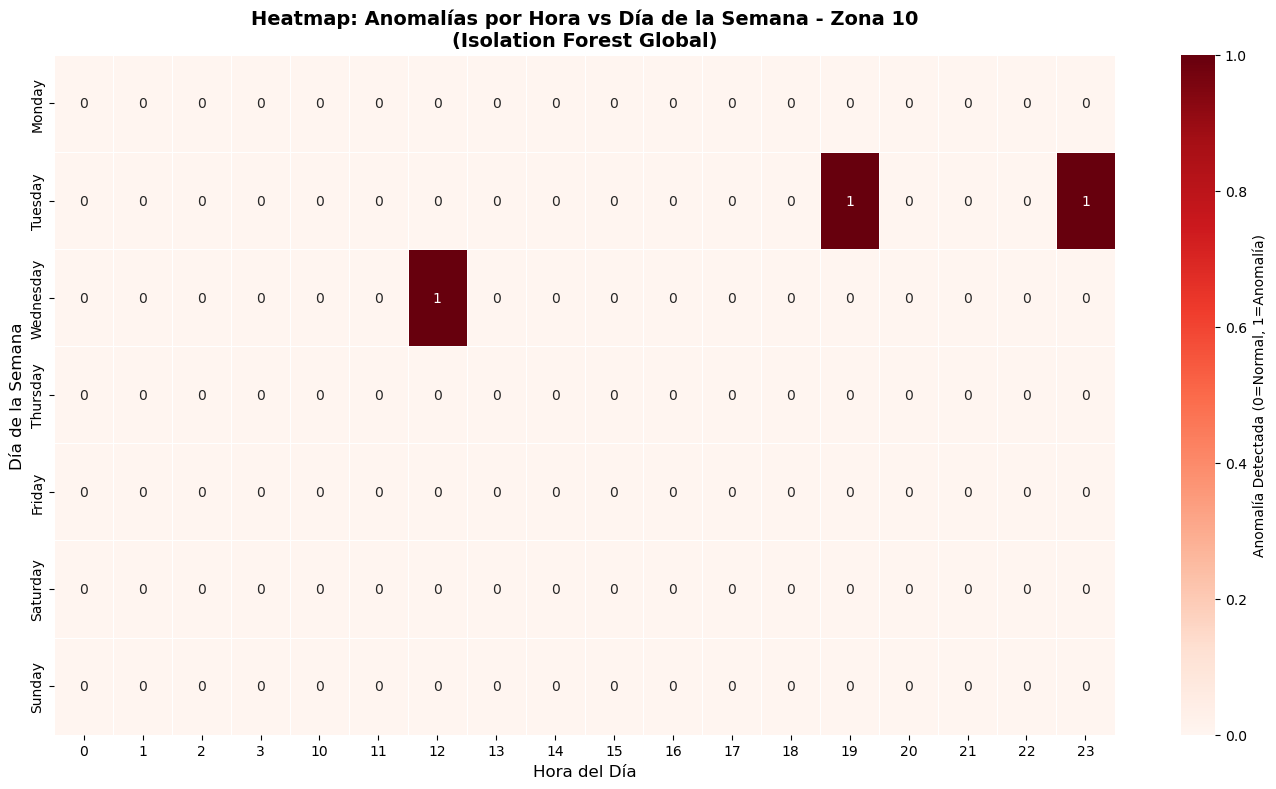


Estadísticas del Heatmap Semanal:
Total de combinaciones hora-día posibles: 126
Combinaciones con anomalías detectadas: 3
Porcentaje de combinaciones con anomalías: 2.38%


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. HEATMAP: Hora vs Día de la Semana
print("=== HEATMAP 1: HORA vs DÍA DE LA SEMANA ===")

# Crear matriz de anomalías por hora y día de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
horas = sorted(zona_10_data_if['hora'].unique())

# Crear matriz bidimensional
matriz_anomalias_semanal = np.zeros((len(dias_orden), len(horas)))

# Llenar la matriz
for i, dia in enumerate(dias_orden):
    for j, hora in enumerate(horas):
        datos_filtrados = zona_10_data_if[
            (zona_10_data_if['dia_semana'] == dia) & 
            (zona_10_data_if['hora'] == hora)
        ]
        if len(datos_filtrados) > 0:
            matriz_anomalias_semanal[i, j] = datos_filtrados['is_anomaly'].max()  # 1 si hay anomalía, 0 si no

# Crear el heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(matriz_anomalias_semanal, 
            xticklabels=horas,
            yticklabels=dias_orden,
            cmap='Reds',
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Anomalía Detectada (0=Normal, 1=Anomalía)'},
            linewidths=0.5)

plt.title(f'Heatmap: Anomalías por Hora vs Día de la Semana - Zona {zona_analisis}\n(Isolation Forest Global)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Día de la Semana', fontsize=12)
plt.tight_layout()
plt.show()

# Estadísticas del heatmap semanal
total_celdas = len(dias_orden) * len(horas)
celdas_con_anomalias = np.sum(matriz_anomalias_semanal > 0)
print(f"\nEstadísticas del Heatmap Semanal:")
print(f"Total de combinaciones hora-día posibles: {total_celdas}")
print(f"Combinaciones con anomalías detectadas: {celdas_con_anomalias}")
print(f"Porcentaje de combinaciones con anomalías: {celdas_con_anomalias/total_celdas*100:.2f}%")

## 2. Heatmap: Hora vs Fecha - Isolation Forest Global (Zona 10)

=== HEATMAP 2: HORA vs FECHA ===


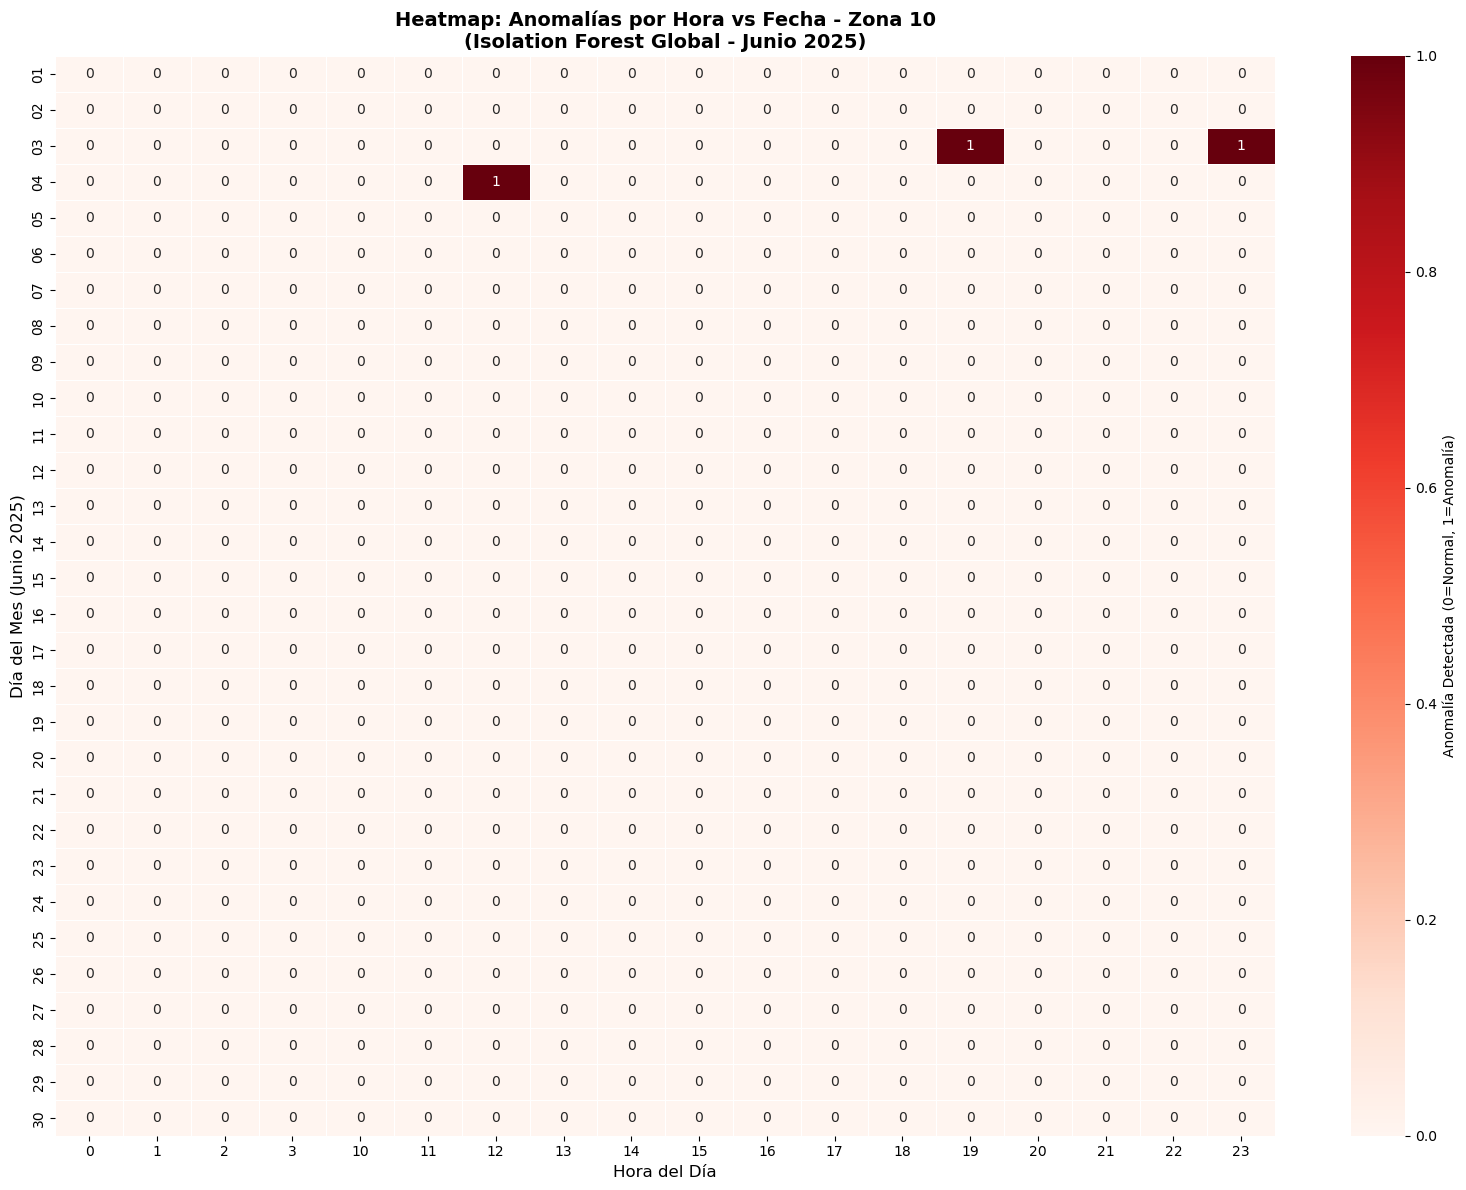


Estadísticas del Heatmap por Fecha:
Total de combinaciones hora-fecha posibles: 540
Combinaciones con anomalías detectadas: 3
Porcentaje de combinaciones con anomalías: 0.56%
Fechas con anomalías: 30 días analizados


In [66]:
# 2. HEATMAP: Hora vs Fecha
print("=== HEATMAP 2: HORA vs FECHA ===")

# Obtener fechas y horas únicas
fechas_unicas = sorted(zona_10_data_if['fecha'].unique())
horas_unicas = sorted(zona_10_data_if['hora'].unique())

# Crear matriz para el heatmap fecha-hora
matriz_anomalias_fecha = np.zeros((len(fechas_unicas), len(horas_unicas)))

# Llenar la matriz
for i, fecha in enumerate(fechas_unicas):
    for j, hora in enumerate(horas_unicas):
        datos_filtrados = zona_10_data_if[
            (zona_10_data_if['fecha'] == fecha) & 
            (zona_10_data_if['hora'] == hora)
        ]
        if len(datos_filtrados) > 0:
            matriz_anomalias_fecha[i, j] = datos_filtrados['is_anomaly'].max()

# Crear el heatmap con fechas
plt.figure(figsize=(16, 12))

# Crear etiquetas de fecha más legibles (solo día del mes)
fecha_labels = [f"{fecha.day:02d}" for fecha in fechas_unicas]

sns.heatmap(matriz_anomalias_fecha, 
            xticklabels=horas_unicas,
            yticklabels=fecha_labels,
            cmap='Reds',
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Anomalía Detectada (0=Normal, 1=Anomalía)'},
            linewidths=0.5)

plt.title(f'Heatmap: Anomalías por Hora vs Fecha - Zona {zona_analisis}\n(Isolation Forest Global - Junio 2025)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Día del Mes (Junio 2025)', fontsize=12)
plt.tight_layout()
plt.show()

# Estadísticas del heatmap por fecha
total_celdas_fecha = len(fechas_unicas) * len(horas_unicas)
celdas_con_anomalias_fecha = np.sum(matriz_anomalias_fecha > 0)
print(f"\nEstadísticas del Heatmap por Fecha:")
print(f"Total de combinaciones hora-fecha posibles: {total_celdas_fecha}")
print(f"Combinaciones con anomalías detectadas: {celdas_con_anomalias_fecha}")
print(f"Porcentaje de combinaciones con anomalías: {celdas_con_anomalias_fecha/total_celdas_fecha*100:.2f}%")
print(f"Fechas con anomalías: {len(fechas_unicas)} días analizados")

## 3. Informe Detallado de Alarmas - Zona 10

In [67]:
# 3. INFORME DETALLADO DE ALARMAS
print("=" * 70)
print(f"📋 INFORME DE ALARMAS PARA ZONA {zona_analisis}")
print("   (Modelo: Isolation Forest Global)")
print("=" * 70)

# Filtrar solo las anomalías
anomalias_detectadas = zona_10_data_if[zona_10_data_if['is_anomaly'] == 1].copy()

if len(anomalias_detectadas) > 0:
    # Crear el informe detallado
    informe_zona_10 = []
    
    for idx, row in anomalias_detectadas.iterrows():
        timestamp = row['timestamp']
        dia_semana = timestamp.strftime('%A')
        dia_semana_es = {
            'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
            'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
        }[dia_semana]
        
        informe_zona_10.append({
            'timestamp': timestamp.strftime('%Y-%m-%d %H:%M'),
            'dia_semana': dia_semana_es,
            'transacciones': int(row['transaction_count_original']),
            'transacciones_estimadas': round(row['transaction_count'], 2),
            'ocupacion': int(row['occupied_spots_original']),
            'ocupacion_estimada': round(row['occupied_spots'], 2),
            'ingresos_reales': round(row['total_net_revenue_original'], 2),
            'ingresos_estimados': round(row['total_net_revenue'], 2),
            'tasa_ocupacion': round(row['occupancy_rate'], 2)
        })
    
    # Mostrar el informe
    print(f"\n🚨 Total de alarmas detectadas: {len(anomalias_detectadas)}")
    print(f"📊 Período analizado: {zona_10_data_if['timestamp'].min().strftime('%Y-%m-%d')} a {zona_10_data_if['timestamp'].max().strftime('%Y-%m-%d')}")
    print(f"📈 Total de observaciones: {len(zona_10_data_if)}")
    print(f"⚠️  Porcentaje de anomalías: {(len(anomalias_detectadas)/len(zona_10_data_if)*100):.2f}%")
    
    print(f"\n" + "─" * 70)
    print(f"{'TIMESTAMP':<17} {'DÍA':<11} {'TRANS':<6} {'T_EST':<6} {'OCUP':<5} {'O_EST':<6} {'INGRESO':<8}")
    print("─" * 70)
    
    for alarma in informe_zona_10:
        print(f"{alarma['timestamp']:<17} {alarma['dia_semana']:<11} "
              f"{alarma['transacciones']:<6} {alarma['transacciones_estimadas']:<6.1f} "
              f"{alarma['ocupacion']:<5} {alarma['ocupacion_estimada']:<6.1f} "
              f"${alarma['ingresos_reales']:<7.2f}")
    
    print("─" * 70)
    print("LEYENDA:")
    print("  TRANS = Transacciones reales | T_EST = Transacciones estimadas por modelo")
    print("  OCUP = Espacios ocupados reales | O_EST = Ocupación estimada por modelo")
    print("  INGRESO = Ingresos netos reales")
    
else:
    print(f"\n✅ No se detectaron anomalías en la zona {zona_analisis} durante el período analizado.")
    print(f"📊 Total de observaciones analizadas: {len(zona_10_data_if)}")
    print(f"📅 Período: {zona_10_data_if['timestamp'].min().strftime('%Y-%m-%d')} a {zona_10_data_if['timestamp'].max().strftime('%Y-%m-%d')}")

print("\n" + "=" * 70)

📋 INFORME DE ALARMAS PARA ZONA 10
   (Modelo: Isolation Forest Global)

🚨 Total de alarmas detectadas: 3
📊 Período analizado: 2025-06-01 a 2025-06-30
📈 Total de observaciones: 212
⚠️  Porcentaje de anomalías: 1.42%

──────────────────────────────────────────────────────────────────────
TIMESTAMP         DÍA         TRANS  T_EST  OCUP  O_EST  INGRESO 
──────────────────────────────────────────────────────────────────────
2025-06-03 19:00  Martes      1      9.0    2     5.7    $5.23   
2025-06-03 23:00  Martes      2      3.0    3     5.3    $20.46  
2025-06-04 12:00  Miércoles   3      3.9    3     5.3    $45.69  
──────────────────────────────────────────────────────────────────────
LEYENDA:
  TRANS = Transacciones reales | T_EST = Transacciones estimadas por modelo
  OCUP = Espacios ocupados reales | O_EST = Ocupación estimada por modelo
  INGRESO = Ingresos netos reales

